# ==============================================================================
# Phase 0 : Configuration et Chargement des Données
# ==============================================================================

* Objectif : Importer toutes les bibliothèques nécessaires pour le prétraitement, la modélisation, l'évaluation et l'explicabilité. Charger le dataset et effectuer une vérification initiale.
Bibliothèques clés :
- Pandas, Numpy : Manipulation de données.
- Matplotlib, Seaborn : Visualisation.
- NLTK : Prétraitement de texte (stopwords, stemming/lemmatisation).
- Scikit-learn : Outils ML essentiels (split, vectorisation, modèles, métriques, pipelines, transformation de colonnes, validation croisée, recherche d'hyperparamètres).
- XGBoost : Modèle de gradient boosting performant.
- joblib : Sauvegarde et chargement des modèles/pipelines.
- shap : Bibliothèque pour l'explicabilité des modèles (optionnelle mais recommandée).
- Configuration : SEED est défini pour assurer la reproductibilité des étapes aléatoires (comme le train/test split).
- Chargement : Le fichier CSV est chargé. Des vérifications de base (head, info) sont effectuées. Une gestion d'erreur simple est ajoutée pour le cas où le fichier ne serait pas trouvé.

In [1]:
# cd "C:\Users\donfa\OneDrive\Desktop\INFO DESCISIONELLE\PROJET INFO DES"

C:\Users\donfa\OneDrive\Desktop\INFO DESCISIONELLE\PROJET INFO DES


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib # Pour sauvegarder/charger les modèles
import warnings

# NLTK pour le prétraitement
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer # Alternative: souvent mieux que PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet') # Si utilisation de WordNetLemmatizer

# Scikit-learn : Préparation, Modèles, Métriques, Pipelines
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer
)

# Explicabilité
try:
    import shap
    shap.initjs() # Initialisation pour les plots SHAP dans les notebooks
    SHAP_AVAILABLE = True
except ImportError:
    print("SHAP n'est pas installé. L'étape d'explicabilité sera sautée.")
    print("Pour l'installer : pip install shap")
    SHAP_AVAILABLE = False

# Configuration
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore', category=UserWarning) # Ignore certains warnings sklearn/nltk
sns.set(style="whitegrid")
SEED = 42 # Pour la reproductibilité

# Chargement des données
try:
    df = pd.read_csv('Data/sentiment_analysis.csv')
    print("Dataset chargé avec succès.")
    print(f"Dimensions initiales : {df.shape}")
except FileNotFoundError:
    print("Erreur : Fichier CSV non trouvé. Vérifiez le chemin d'accès.")
    # Possibilité de stopper l'exécution ou d'utiliser un chemin alternatif
    exit() # Ou raise Exception("Fichier non trouvé")

# Afficher un aperçu
print("\nAperçu des données :")
display(df.head())
print("\nInformations sur les colonnes :")
df.info()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\donfa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\donfa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\donfa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Erreur : Fichier CSV non trouvé. Vérifiez le chemin d'accès.

Aperçu des données :


NameError: name 'df' is not defined

: 

In [ ]:
from xgboost import XGBClassifier


# ==============================================================================
# Phase 1 : Prétraitement et Préparation des Données
# ==============================================================================

* Objectif : Préparer les données pour l'entraînement : nettoyer le texte, encoder la variable cible, définir les ensembles de features et la cible, et séparer les données en ensembles d'entraînement et de test.
- Prétraitement Texte : La fonction preprocess_text_stemming (inspirée du Code 1) est utilisée pour nettoyer et normaliser le texte (minuscules, suppression caractères non alpha, suppression stopwords, stemming). Une colonne cleaned_text est créée. Note : La lemmatisation pourrait être une alternative plus qualitative.
- Encodage Cible : La colonne sentiment est transformée en sentiment_encoded avec le mapping {'neutral': 0, 'positive': 1, 'negative': 2}. C'est un format standard pour la classification multi-classe dans Scikit-learn. La distribution est vérifiée.
- Features & Cible : X contient toutes les colonnes sauf la cible (originale et encodée). y contient la cible encodée.
- Train/Test Split : Les données sont divisées en 80% pour l'entraînement (X_train, y_train) et 20% pour le test (X_test, y_test). stratify=y assure que la proportion de chaque sentiment est préservée dans les deux ensembles, ce qui est crucial pour une évaluation fiable, surtout avec un léger déséquilibre des classes. Les tailles et distributions sont vérifiées.
- Définition Colonnes : Les noms des colonnes à utiliser pour le texte (text_feature) et les métadonnées (metadata_features) sont définis pour faciliter leur utilisation ultérieure.

### mais avant comme vu pendant l'analyse exploratoire les noms des plateformes et les colones nulles posen des soucis 

In [ ]:
# dans cette version je garde les doublons
# df.drop_duplicates(inplace=True)
# print("Doublons supprimés.")
# df.reset_index(drop=True, inplace=True) # Réinitialiser l'index après suppression
df['Platform'] = df['Platform'].str.strip()
print("Soucis de noms de plateforme OK")


Soucis de noms de plateforme OK


### 1.1 Nettoyage du texte (Fonction de stemming comme dans Code 1)


In [ ]:

ps = PorterStemmer()
# lemmatizer = WordNetLemmatizer() # Alternative
stop_words = set(stopwords.words('english'))

def preprocess_text_stemming(text):
    text = str(text).lower() # Minuscule
    text = re.sub(r'[^a-z\s]', '', text) # Garde seulement lettres et espaces
    tokens = text.split() # Tokenisation simple
    # Stemming et suppression des stopwords
    stemmed_tokens = [ps.stem(word) for word in tokens if word not in stop_words and len(word) > 1]
    # Rejoint les mots
    return " ".join(stemmed_tokens)

# Appliquer le prétraitement
df['cleaned_text'] = df['text'].apply(preprocess_text_stemming)
print("\nComparaison Texte Original vs Nettoyé :")
display(df[['text', 'cleaned_text']].head())



Comparaison Texte Original vs Nettoyé :


,text,cleaned_text
0,What a great day!!! Looks like dream.,great day look like dream
1,"I feel sorry, I miss you here in the sea beach",feel sorri miss sea beach
2,Don't angry me,dont angri
3,We attend in the class just for listening teac...,attend class listen teacher read slide nonsenc
4,"Those who want to go, let them go",want go let go


### 1.2 Encodage de la variable cible ('sentiment')

In [ ]:

# On va utiliser 0: neutral, 1: positive, 2: negative (comme dans Code 1)
# La fonction finale de prédiction fera le mapping vers 0, 1, -1 si besoin.
sentiment_map = {'neutral': 0, 'positive': 1, 'negative': 2}
df['sentiment_encoded'] = df['sentiment'].map(sentiment_map)

# Vérifier l'encodage et la distribution
print("\nDistribution des sentiments encodés :")
print(df['sentiment_encoded'].value_counts())
print(f"Valeurs manquantes dans sentiment_encoded : {df['sentiment_encoded'].isnull().sum()}")

# Définition des Features (X) et de la Cible (y)
df_features = df.copy() # Garder une copie de df avec 'text' original
# 'cleaned_text' et 'sentiment_encoded' sont déjà dans df_features grâce aux étapes précédentes
y = df_features['sentiment_encoded']
X = df_features.drop(['sentiment', 'sentiment_encoded'], axis=1) # X contient maintenant 'text', 'cleaned_text', etc.
y = df['sentiment_encoded'] # Cible encodée



Distribution des sentiments encodés :
sentiment_encoded
0    199
1    166
2    134
Name: count, dtype: int64
Valeurs manquantes dans sentiment_encoded : 0


### 1.3 Séparation Entraînement / Test (Stratifiée)

In [ ]:

# On sépare tout le DataFrame X pour garder les métadonnées disponibles
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.35, # 20% pour le test (comme Code 1)
    random_state=SEED,
    stratify=y # Très important pour garder les proportions de sentiments
)

print(f"\nTaille du jeu d'entraînement : {X_train.shape}, {y_train.shape}")
print(f"Taille du jeu de test : {X_test.shape}, {y_test.shape}")
print("\nDistribution des sentiments dans y_train:")
print(y_train.value_counts(normalize=True))
print("\nDistribution des sentiments dans y_test:")
print(y_test.value_counts(normalize=True)) # Doit être similaire à y_train

# Définir les colonnes pour les différents types de modèles
text_feature = 'cleaned_text'
metadata_features = ['Platform', 'Time of Tweet'] # Colonnes identifiées comme pertinentes


Taille du jeu d'entraînement : (324, 7), (324,)
Taille du jeu de test : (175, 7), (175,)

Distribution des sentiments dans y_train:
sentiment_encoded
0    0.398148
1    0.333333
2    0.268519
Name: proportion, dtype: float64

Distribution des sentiments dans y_test:
sentiment_encoded
0    0.400000
1    0.331429
2    0.268571
Name: proportion, dtype: float64


# ==============================================================================
# Phase 2 : Entraînement et Évaluation - Modèles "Text Only"
# ==============================================================================

* Objectif : Entraîner et évaluer plusieurs modèles de classification en utilisant uniquement les données textuelles (cleaned_text). Comparer leurs performances pour identifier les candidats potentiels.
* Pipeline text_pipeline : Un Pipeline Scikit-learn est défini. Il enchaîne :
- TfidfVectorizer : Transforme le texte en vecteurs TF-IDF. max_features=5000 limite la taille du vocabulaire pour éviter une dimensionnalité trop élevée. ngram_range=(1, 2) inclut les mots seuls (unigrammes) et les paires de mots (bigrammes), ce qui capture un peu plus de contexte que les unigrammes seuls (comme dans le Code 2 qui utilisait TF-IDF avec unigrammes par défaut). C'est un compromis par rapport au ngram_range=(1, 5) du Code 1 qui utilisait CountVectorizer et pouvait générer beaucoup trop de features.
- classifier : Un espace réservé qui sera remplacé par chaque modèle testé.
* Modèles Testés : Une sélection de classifieurs classiques et performants :
- LogisticRegression : Bon baseline, souvent efficace pour le texte.
- MultinomialNB : Classifieur Naive Bayes adapté aux données de comptage (comme BoW ou TF-IDF). Rapide.
- SVC (Linear) : Support Vector Machine avec noyau linéaire, souvent performant sur des données de haute dimension comme le texte vectorisé.
- XGBoost : Algorithme de Gradient Boosting puissant, peut capturer des interactions complexes. Les paramètres sont définis (moins d'arbres que dans le Code 2 pour un premier test rapide).
* Boucle d'Entraînement/Évaluation :
Chaque modèle est inséré dans le pipeline.
Le pipeline complet est entraîné sur les textes de X_train.
Les prédictions sont faites sur les textes de X_test.
- L'évaluation est effectuée en utilisant :
- accuracy_score : Pourcentage de prédictions correctes.
- f1_score(average='weighted') : Moyenne pondérée du F1-score par classe. C'est une métrique robuste, surtout en cas de léger déséquilibre des classes, car elle équilibre précision et rappel.
- classification_report : Donne la précision, le rappel, le F1-score pour chaque classe. Très utile pour voir si le modèle performe bien sur toutes les classes ou s'il a des difficultés avec certaines (par ex. la classe 'negative' qui a le moins d'exemples).
- confusion_matrix : Tableau montrant les prédictions correctes et incorrectes pour chaque classe (vrai vs prédit). Permet d'identifier les types d'erreurs les plus courants (ex: confusion entre 'neutral' et 'negative').
Les résultats et le pipeline entraîné sont stockés dans results_text_only.
Une heatmap de la matrice de confusion est affichée pour chaque modèle.
- Comparaison : Les scores (Accuracy, F1 Weighted) sont rassemblés dans un DataFrame et visualisés dans un graphique à barres pour comparer facilement les performances globales des modèles testés.

### 2.1 Définition du Pipeline "Text Only"

In [ ]:
print("\n" + "="*50)
print(" Phase 2 : Modèles basés uniquement sur le Texte ")
print("="*50 + "\n")

# Le pipeline inclura la vectorisation TF-IDF et le classifieur
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))), # TF-IDF avec bigrammes, limite features
    ('classifier', None) # Placeholder pour le modèle
])

# Modèles à tester
models_to_test = {
    "Logistic Regression": LogisticRegression(random_state=SEED, max_iter=1000, C=1.0, solver='liblinear'),
    "Multinomial NB": MultinomialNB(alpha=1.0),
    "SVC (Linear)": SVC(kernel='linear', probability=True, random_state=SEED, C=1.0), # probability=True pour SHAP si besoin
    "XGBoost": XGBClassifier(objective='multi:softmax', num_class=3, use_label_encoder=False,
                             eval_metric='mlogloss', random_state=SEED, n_estimators=300, # Moins d'estimateurs que Code 2 pour commencer
                             learning_rate=0.1, max_depth=3, subsample=0.7, colsample_bytree=0.7)
}



 Phase 2 : Modèles basés uniquement sur le Texte 



### 2.2 Boucle d'entraînement et d'évaluation


--- Entraînement et Évaluation : Logistic Regression ---
Accuracy: 0.6971
F1-Score (Weighted): 0.6886
Classification Report:
               precision    recall  f1-score   support

 neutral (0)       0.63      0.89      0.73        70
positive (1)       0.76      0.66      0.70        58
negative (2)       0.85      0.47      0.60        47

    accuracy                           0.70       175
   macro avg       0.74      0.67      0.68       175
weighted avg       0.73      0.70      0.69       175

Confusion Matrix:
 [[62  8  0]
 [16 38  4]
 [21  4 22]]


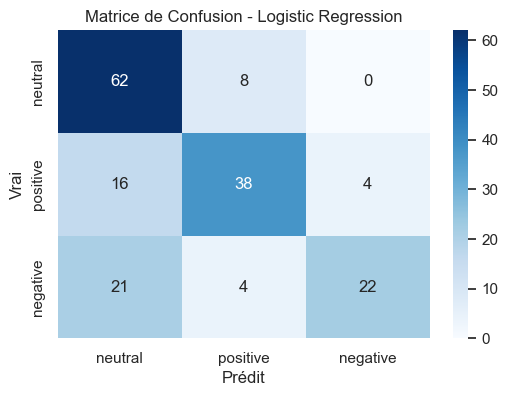


--- Entraînement et Évaluation : Multinomial NB ---
Accuracy: 0.6514
F1-Score (Weighted): 0.6379
Classification Report:
               precision    recall  f1-score   support

 neutral (0)       0.60      0.80      0.68        70
positive (1)       0.71      0.71      0.71        58
negative (2)       0.74      0.36      0.49        47

    accuracy                           0.65       175
   macro avg       0.68      0.62      0.63       175
weighted avg       0.67      0.65      0.64       175

Confusion Matrix:
 [[56 11  3]
 [14 41  3]
 [24  6 17]]


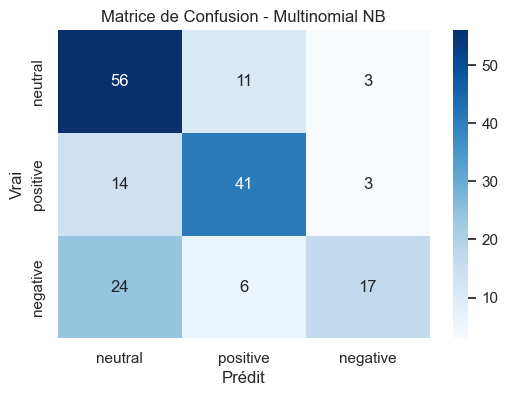


--- Entraînement et Évaluation : SVC (Linear) ---
Accuracy: 0.7143
F1-Score (Weighted): 0.7119
Classification Report:
               precision    recall  f1-score   support

 neutral (0)       0.70      0.81      0.75        70
positive (1)       0.72      0.67      0.70        58
negative (2)       0.74      0.62      0.67        47

    accuracy                           0.71       175
   macro avg       0.72      0.70      0.71       175
weighted avg       0.72      0.71      0.71       175

Confusion Matrix:
 [[57  9  4]
 [13 39  6]
 [12  6 29]]


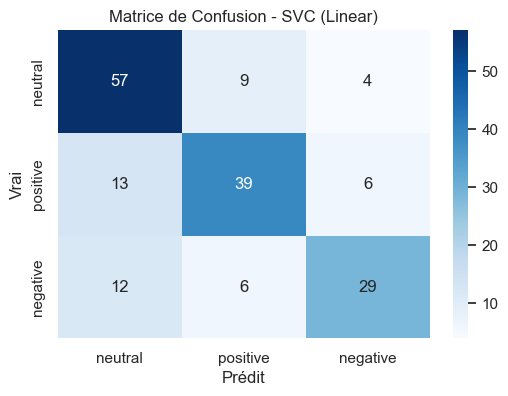


--- Entraînement et Évaluation : XGBoost ---
Accuracy: 0.6400
F1-Score (Weighted): 0.6367
Classification Report:
               precision    recall  f1-score   support

 neutral (0)       0.59      0.77      0.67        70
positive (1)       0.71      0.55      0.62        58
negative (2)       0.67      0.55      0.60        47

    accuracy                           0.64       175
   macro avg       0.66      0.63      0.63       175
weighted avg       0.65      0.64      0.64       175

Confusion Matrix:
 [[54 10  6]
 [19 32  7]
 [18  3 26]]


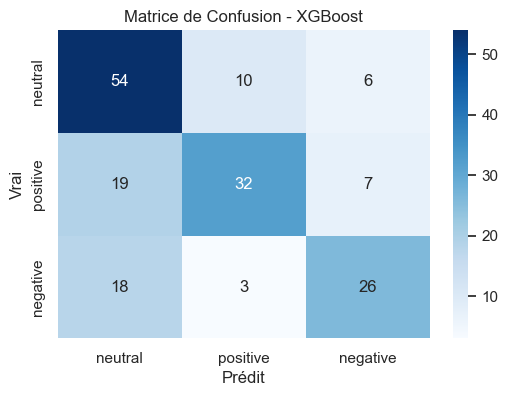

In [ ]:
results_text_only = {}

for model_name, model in models_to_test.items():
    print(f"\n--- Entraînement et Évaluation : {model_name} ---")

    # Mettre à jour le classifieur dans le pipeline
    current_pipeline = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))), # Re-instancier pour être sûr
        ('classifier', model)
    ])

    # Entraînement sur X_train[text_feature]
    current_pipeline.fit(X_train[text_feature], y_train)

    # Prédictions sur X_test[text_feature]
    y_pred = current_pipeline.predict(X_test[text_feature])

    # Évaluation
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted') # Weighted F1 est bon pour déséquilibre léger
    report = classification_report(y_test, y_pred, target_names=['neutral (0)', 'positive (1)', 'negative (2)'])
    cm = confusion_matrix(y_test, y_pred)

    results_text_only[model_name] = {
        'model': current_pipeline, # Sauvegarde du pipeline entraîné
        'accuracy': accuracy,
        'f1_weighted': f1,
        'report': report,
        'confusion_matrix': cm
    }

    # Affichage des résultats
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", cm)

    # Visualisation de la Matrice de Confusion
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['neutral', 'positive', 'negative'],
                yticklabels=['neutral', 'positive', 'negative'])
    plt.title(f'Matrice de Confusion - {model_name}')
    plt.xlabel('Prédit')
    plt.ylabel('Vrai')
    plt.show()


### Le SVC (super vector machine) avec noyau lineaire semble etre le model le plus precis en attendant XGBoost. les resultats sont les suivants :

--- Entraînement et Évaluation : Logistic Regression ---
Accuracy: 0.4177
F1-Score (Weighted): 0.3783
Classification Report:
               precision    recall  f1-score   support

 neutral (0)       0.41      0.65      0.50        31
positive (1)       0.42      0.42      0.42        26
negative (2)       0.50      0.09      0.15        22

    accuracy                           0.42        79
   macro avg       0.44      0.39      0.36        79
weighted avg       0.44      0.42      0.38        79

Confusion Matrix:
 [[20  9  2]
 [15 11  0]
 [14  6  2]]
 

--- Entraînement et Évaluation : Multinomial NB ---
Accuracy: 0.4430
F1-Score (Weighted): 0.3877
Classification Report:
               precision    recall  f1-score   support

 neutral (0)       0.43      0.68      0.53        31
positive (1)       0.46      0.50      0.48        26
negative (2)       0.50      0.05      0.08        22

    accuracy                           0.44        79
   macro avg       0.46      0.41      0.36        79
weighted avg       0.46      0.44      0.39        79

Confusion Matrix:
 [[21  9  1]
 [13 13  0]
 [15  6  1]]
 

--- Entraînement et Évaluation : SVC (Linear) ---
Accuracy: 0.4430
F1-Score (Weighted): 0.4308
Classification Report:
               precision    recall  f1-score   support

 neutral (0)       0.42      0.55      0.48        31
positive (1)       0.46      0.50      0.48        26
negative (2)       0.45      0.23      0.30        22

    accuracy                           0.44        79
   macro avg       0.45      0.43      0.42        79
weighted avg       0.45      0.44      0.43        79

Confusion Matrix:
 [[17 10  4]
 [11 13  2]
 [12  5  5]]

### 2.3 Comparaison des modèles "Text Only"


--- Comparaison des Modèles (Text Only) ---
                     Accuracy  F1 Weighted
SVC (Linear)         0.714286     0.711946
Logistic Regression  0.697143     0.688597
Multinomial NB       0.651429     0.637905
XGBoost              0.640000     0.636651


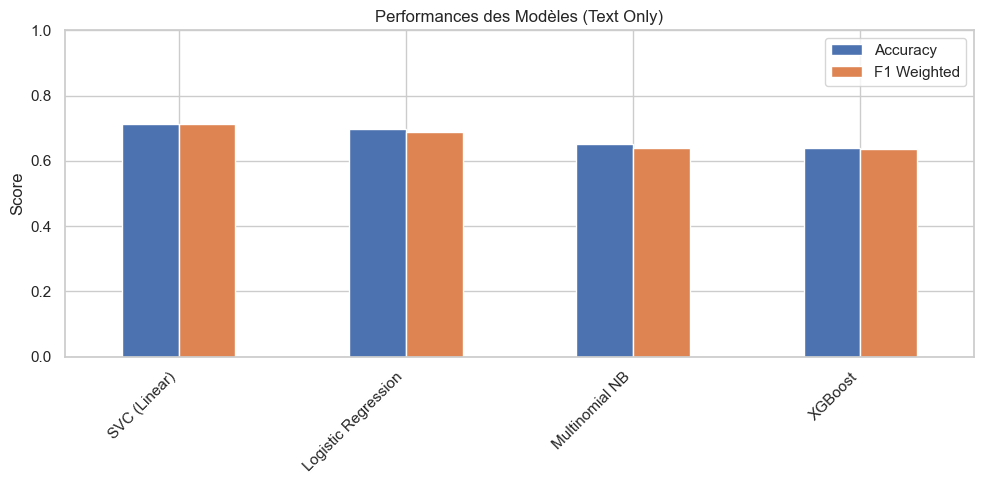

In [ ]:
print("\n--- Comparaison des Modèles (Text Only) ---")
results_df_text = pd.DataFrame({
    model: {'Accuracy': res['accuracy'], 'F1 Weighted': res['f1_weighted']}
    for model, res in results_text_only.items()
}).T.sort_values(by='F1 Weighted', ascending=False)

print(results_df_text)
results_df_text.plot(kind='bar', figsize=(10, 5), title='Performances des Modèles (Text Only)')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

### nous partirons donc sur le SV linear

# ==============================================================================
# Phase 3 : Analyse de l'Overfitting (Courbes d'Apprentissage)
# ==============================================================================

### Objectif : Diagnostiquer si les modèles souffrent de sur apprentissage (overfitting) ou de sous-apprentissage (underfitting) en analysant leur performance en fonction de la taille du jeu de données d'entraînement.
- Courbes d'Apprentissage (learning_curve) : Cette fonction de Scikit-learn entraîne le modèle sur des sous-ensembles croissants du jeu d'entraînement et évalue sa performance (ici, le F1-score pondéré) à la fois sur ces sous-ensembles (score d'entraînement) et sur un jeu de validation croisée (score de validation).
- Fonction plot_learning_curve : Une fonction utilitaire est définie pour générer et afficher les courbes. Elle utilise StratifiedKFold pour la validation croisée, ce qui est approprié pour la classification stratifiée. Le F1-score pondéré est utilisé comme métrique.
- Interprétation des Courbes :
- Surapprentissage (High Variance) : La courbe d'entraînement montre un score très élevé (proche de 1.0) qui reste élevé même avec plus de données, tandis que la courbe de validation stagne à un niveau nettement inférieur. Il y a un grand écart entre les deux courbes. Le modèle mémorise trop bien les données d'entraînement et ne généralise pas. Actions possibles : Réduire la complexité du modèle (régularisation plus forte, moins de features, moins de profondeur pour les arbres), obtenir plus de données.
- Sous-apprentissage (High Bias) : Les deux courbes (entraînement et validation) convergent vers un score relativement bas. Le modèle est trop simple pour capturer la structure des données. Actions possibles : Augmenter la complexité du modèle (moins de régularisation, plus de features, modèle plus puissant), améliorer les features.
- Idéal : Les deux courbes convergent vers un score élevé, avec un faible écart entre elles.
- Application : Les courbes sont tracées pour le(s) modèle(s) semblant les plus performants d'après la Phase 2 (ex: le meilleur selon le F1-score et potentiellement XGBoost s'il est différent). L'analyse de ces courbes donne des indications précieuses sur la fiabilité des scores obtenus et sur les pistes d'amélioration éventuelles. Attention : Avec un dataset aussi petit (seulement ~400 points d'entraînement), les courbes peuvent être bruitées et l'overfitting est un risque réel.


 Phase 3 : Analyse de l'Overfitting (Courbes d'Apprentissage) 



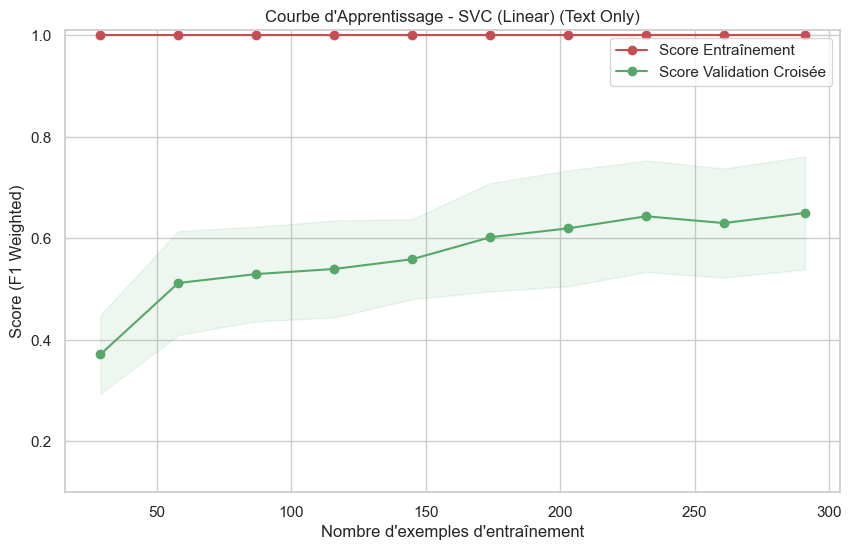

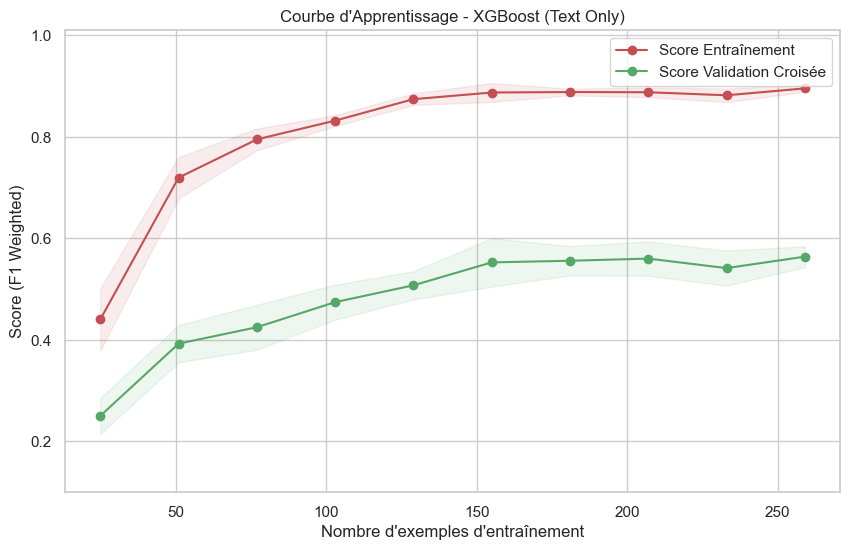

In [ ]:
print("\n" + "="*50)
print(" Phase 3 : Analyse de l'Overfitting (Courbes d'Apprentissage) ")
print("="*50 + "\n")

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Génère une courbe d'apprentissage simple pour un estimateur."""
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Nombre d'exemples d'entraînement")
    plt.ylabel("Score (F1 Weighted)") # On utilise F1 comme score

    # Utiliser StratifiedKFold pour la validation croisée (bon pour la classification)
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    # Utiliser F1-weighted comme métrique de scoring
    f1_scorer = make_scorer(f1_score, average='weighted')

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=f1_scorer)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid(True)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score Entraînement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score Validation Croisée")

    plt.legend(loc="best")
    return plt

# Sélectionner les modèles les plus prometteurs pour l'analyse
# Par exemple, le meilleur modèle du classement précédent et peut-être XGBoost
best_model_name_text = results_df_text.index[0]
model_to_plot1 = results_text_only[best_model_name_text]['model']

# On doit utiliser le pipeline complet ici sur les données textuelles
plot_learning_curve(model_to_plot1, f"Courbe d'Apprentissage - {best_model_name_text} (Text Only)",
                    X_train[text_feature], y_train, ylim=(0.1, 1.01), cv=10)
plt.show()

# Si XGBoost est différent du meilleur, on le trace aussi
if "XGBoost" in results_text_only and best_model_name_text != "XGBoost":
     model_to_plot2 = results_text_only["XGBoost"]['model']
     plot_learning_curve(model_to_plot2, "Courbe d'Apprentissage - XGBoost (Text Only)",
                         X_train[text_feature], y_train, ylim=(0.1, 1.01), cv=5)
     plt.show()

### Il n'y a donc pas de surapprentissage ou presque car on voit que le nombre d'elements ideal pour un bon F1-score est d'environ 225 soit pres de 65% du dataset , 

# ==============================================================================
# Phase 4 : Entraînement et Évaluation - Modèles "Text + Metadata"
# ==============================================================================

### Objectif : Entraîner et évaluer des modèles en utilisant à la fois le texte et les métadonnées jugées pertinentes (Platform, Time of Tweet). Comparer leurs performances à celles des modèles "Text Only" pour déterminer si les métadonnées apportent une amélioration significative.
- ColumnTransformer : C'est l'outil clé pour appliquer différents prétraitements à différentes colonnes. Ici :
Le TfidfVectorizer (avec les mêmes paramètres que précédemment) est appliqué à la colonne cleaned_text.
Le OneHotEncoder est appliqué aux colonnes Platform et Time of Tweet. Le One-Hot Encoding transforme chaque catégorie en une nouvelle colonne binaire (0 ou 1), ce qui est une manière standard de traiter les features catégorielles pour la plupart des modèles. handle_unknown='ignore' est important pour que le modèle ne plante pas s'il rencontre une catégorie dans les données de test qui n'était pas présente dans l'entraînement.
- Pipeline full_pipeline : Ce pipeline intègre maintenant le ColumnTransformer comme première étape, suivi du classifieur.
- Modèles Testés : La sélection peut être ajustée. LogisticRegression et XGBoost sont généralement de bons candidats car ils gèrent bien les features hétérogènes (sparse TF-IDF + dense One-Hot).
- Entraînement/Évaluation : Le processus est similaire à la Phase 2, mais le pipeline complet est entraîné sur X_train (qui contient toutes les colonnes nécessaires) et évalué sur X_test. Le ColumnTransformer se charge de sélectionner et traiter les bonnes colonnes.
- Comparaisons :
Les performances des modèles "Text + Metadata" sont comparées entre eux.
Une comparaison globale est effectuée entre les meilleurs modèles "Text Only" et les meilleurs modèles "Text + Metadata" (basée sur le F1-score pondéré). Cela permet de répondre à la question : L'ajout des métadonnées améliore-t-il significativement la prédiction du sentiment dans ce cas ? La visualisation aide à voir clairement si un type de modèle surpasse l'autre.


### 4.1 Définition du Préprocesseur Combiné (ColumnTransformer)


In [ ]:

print("\n" + "="*50)
print(" Phase 4 : Modèles basés sur Texte + Métadonnées ")
print("="*50 + "\n")

# Combine le traitement du texte et l'encodage des métadonnées

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=5000, ngram_range=(1, 2)), text_feature),
        ('metadata', OneHotEncoder(handle_unknown='ignore'), metadata_features)
        # handle_unknown='ignore' : si une nouvelle catégorie apparaît dans le test,
        # elle sera encodée comme un vecteur de zéros.
    ],
    remainder='drop' # Ignore les autres colonnes non spécifiées
)

# 4.2 Définition du Pipeline "Text + Metadata"
full_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', None) # Placeholder
])



 Phase 4 : Modèles basés sur Texte + Métadonnées 



### 4.3 Modèles à tester (On peut reprendre les mêmes ou une sélection)

In [ ]:

# Certains modèles comme Naive Bayes sont moins directs avec des features hétérogènes (sparse text + dense OHE)
# Logistic Regression et XGBoost gèrent bien cela. Essayons ceux-là.
models_to_test_full = {
    "Logistic Regression": LogisticRegression(random_state=SEED, max_iter=1000, C=1.0, solver='liblinear'),
    "XGBoost": XGBClassifier(objective='multi:softmax', num_class=3, use_label_encoder=False,
                             eval_metric='mlogloss', random_state=SEED, n_estimators=300,
                             learning_rate=0.1, max_depth=3, subsample=0.7, colsample_bytree=0.7),
    "Multinomial NB": MultinomialNB(alpha=1.0),
    "SVC (Linear)": SVC(kernel='linear', probability=True, random_state=SEED, C=1.0), 
    # On pourrait aussi tester SVC mais l'entraînement peut être plus long
}


### 4.4 Boucle d'entraînement et d'évaluation


--- Entraînement et Évaluation (Full) : Logistic Regression ---
Accuracy: 0.6171
F1-Score (Weighted): 0.6141
Classification Report:
               precision    recall  f1-score   support

 neutral (0)       0.59      0.73      0.65        70
positive (1)       0.57      0.60      0.59        58
negative (2)       0.79      0.47      0.59        47

    accuracy                           0.62       175
   macro avg       0.65      0.60      0.61       175
weighted avg       0.64      0.62      0.61       175

Confusion Matrix:
 [[51 17  2]
 [19 35  4]
 [16  9 22]]


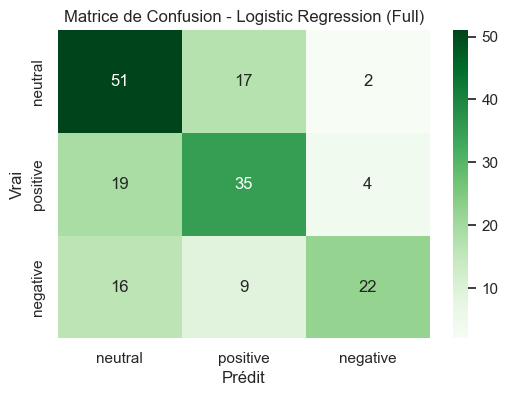


--- Entraînement et Évaluation (Full) : XGBoost ---
Accuracy: 0.6229
F1-Score (Weighted): 0.6177
Classification Report:
               precision    recall  f1-score   support

 neutral (0)       0.59      0.77      0.67        70
positive (1)       0.67      0.52      0.58        58
negative (2)       0.66      0.53      0.59        47

    accuracy                           0.62       175
   macro avg       0.64      0.61      0.61       175
weighted avg       0.63      0.62      0.62       175

Confusion Matrix:
 [[54 10  6]
 [21 30  7]
 [17  5 25]]


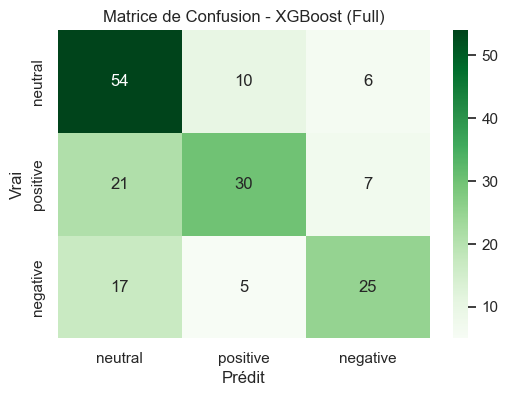


--- Entraînement et Évaluation (Full) : Multinomial NB ---
Accuracy: 0.5657
F1-Score (Weighted): 0.5349
Classification Report:
               precision    recall  f1-score   support

 neutral (0)       0.51      0.84      0.63        70
positive (1)       0.67      0.52      0.58        58
negative (2)       0.71      0.21      0.33        47

    accuracy                           0.57       175
   macro avg       0.63      0.52      0.51       175
weighted avg       0.62      0.57      0.53       175

Confusion Matrix:
 [[59  9  2]
 [26 30  2]
 [31  6 10]]


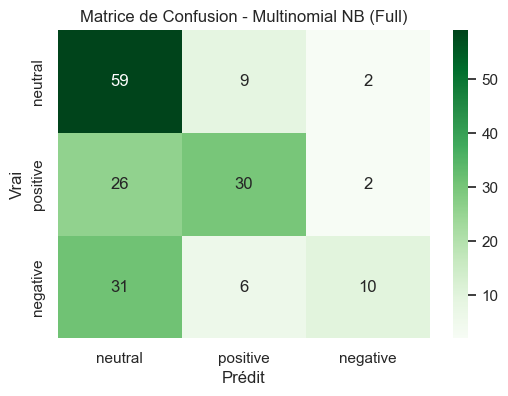


--- Entraînement et Évaluation (Full) : SVC (Linear) ---
Accuracy: 0.6971
F1-Score (Weighted): 0.6971
Classification Report:
               precision    recall  f1-score   support

 neutral (0)       0.68      0.73      0.70        70
positive (1)       0.67      0.71      0.69        58
negative (2)       0.77      0.64      0.70        47

    accuracy                           0.70       175
   macro avg       0.71      0.69      0.70       175
weighted avg       0.70      0.70      0.70       175

Confusion Matrix:
 [[51 14  5]
 [13 41  4]
 [11  6 30]]


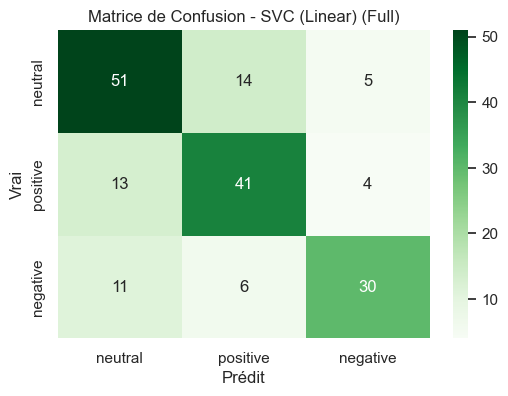

In [ ]:

results_full = {}

for model_name, model in models_to_test_full.items():
    print(f"\n--- Entraînement et Évaluation (Full) : {model_name} ---")

    # Mettre à jour le classifieur dans le pipeline complet
    current_full_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor), # Utilise le ColumnTransformer
        ('classifier', model)
    ])

    # Entraînement sur X_train (qui contient texte et métadonnées)
    current_full_pipeline.fit(X_train, y_train) # Passe tout X_train, ColumnTransformer sélectionne les bonnes colonnes

    # Prédictions sur X_test
    y_pred_full = current_full_pipeline.predict(X_test)

    # Évaluation
    accuracy = accuracy_score(y_test, y_pred_full)
    f1 = f1_score(y_test, y_pred_full, average='weighted')
    report = classification_report(y_test, y_pred_full, target_names=['neutral (0)', 'positive (1)', 'negative (2)'])
    cm = confusion_matrix(y_test, y_pred_full)

    results_full[model_name] = {
        'model': current_full_pipeline, # Sauvegarde du pipeline entraîné
        'accuracy': accuracy,
        'f1_weighted': f1,
        'report': report,
        'confusion_matrix': cm
    }

    # Affichage des résultats
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", cm)

    # Visualisation de la Matrice de Confusion
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['neutral', 'positive', 'negative'],
                yticklabels=['neutral', 'positive', 'negative'])
    plt.title(f'Matrice de Confusion - {model_name} (Full)')
    plt.xlabel('Prédit')
    plt.ylabel('Vrai')
    plt.show()



### 4.5 Comparaison des modèles "Text + Metadata"


--- Comparaison des Modèles (Text + Metadata) ---
                     Accuracy  F1 Weighted
SVC (Linear)         0.697143     0.697134
XGBoost              0.622857     0.617715
Logistic Regression  0.617143     0.614058
Multinomial NB       0.565714     0.534885


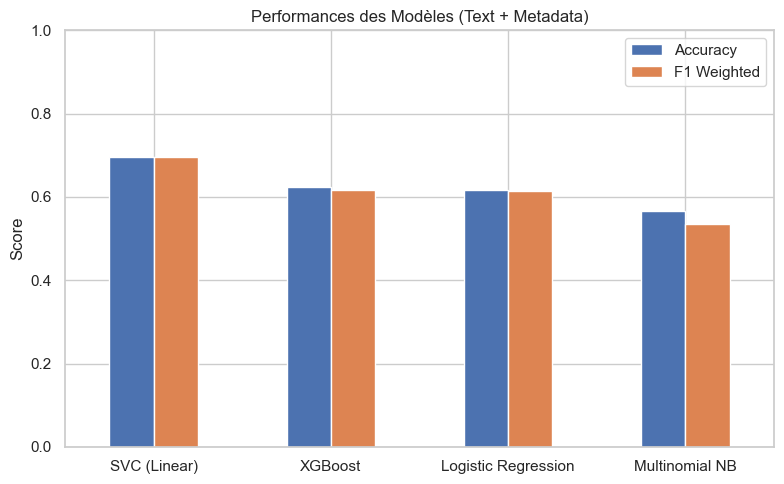

In [ ]:

print("\n--- Comparaison des Modèles (Text + Metadata) ---")
results_df_full = pd.DataFrame({
    model: {'Accuracy': res['accuracy'], 'F1 Weighted': res['f1_weighted']}
    for model, res in results_full.items()
}).T.sort_values(by='F1 Weighted', ascending=False)

print(results_df_full)
results_df_full.plot(kind='bar', figsize=(8, 5), title='Performances des Modèles (Text + Metadata)')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()



### 4.6 Comparaison Globale : Text Only vs Text + Metadata


--- Comparaison Globale : Text Only vs Text + Metadata ---
                     Accuracy  F1 Weighted             Type
SVC (Linear)         0.714286     0.711946        Text Only
SVC (Linear)         0.697143     0.697134  Text + Metadata
Logistic Regression  0.697143     0.688597        Text Only
Multinomial NB       0.651429     0.637905        Text Only
XGBoost              0.640000     0.636651        Text Only
XGBoost              0.622857     0.617715  Text + Metadata
Logistic Regression  0.617143     0.614058  Text + Metadata
Multinomial NB       0.565714     0.534885  Text + Metadata


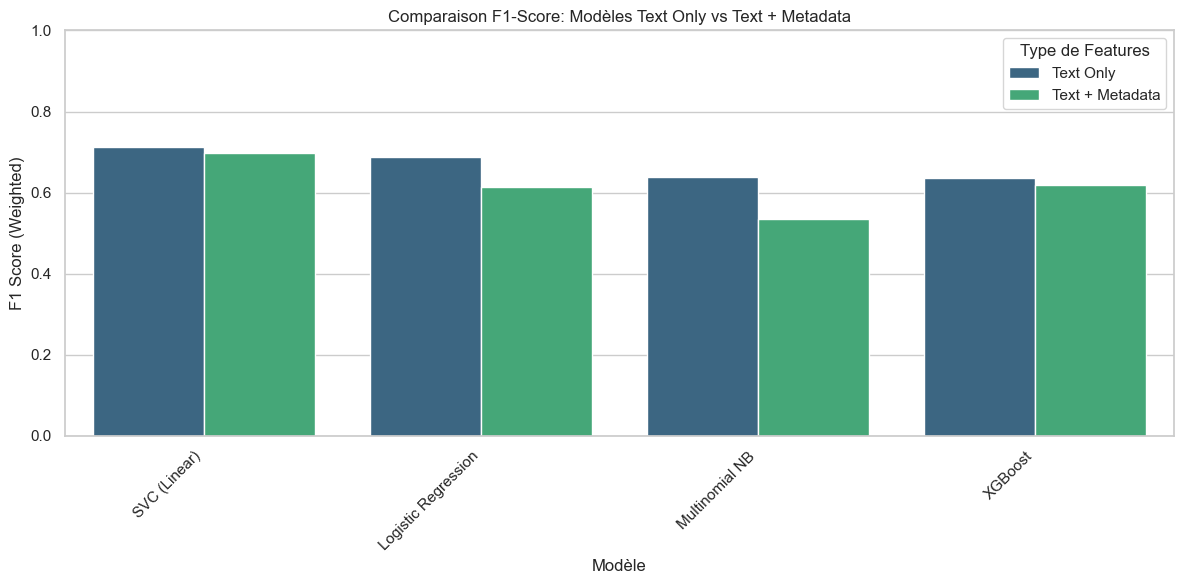

In [ ]:

print("\n--- Comparaison Globale : Text Only vs Text + Metadata ---")
# Concaténer les DataFrames de résultats
all_results_df = pd.concat([
    results_df_text.assign(Type='Text Only'),
    results_df_full.assign(Type='Text + Metadata')
]).sort_values(by='F1 Weighted', ascending=False)

print(all_results_df)

plt.figure(figsize=(12, 6))
sns.barplot(data=all_results_df.reset_index(), x='index', y='F1 Weighted', hue='Type', palette='viridis')
plt.title('Comparaison F1-Score: Modèles Text Only vs Text + Metadata')
plt.xlabel('Modèle')
plt.ylabel('F1 Score (Weighted)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Type de Features')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

### les models les plus efficaces a utiliser semblent donc etre Mutinomial NB ou SVC (linear)

# ==============================================================================
# Phase 5 : Explicabilité du Modèle (SHAP)
# ==============================================================================

### Objectif : Comprendre pourquoi le meilleur modèle prend certaines décisions. Identifier les features (mots, n-grams, ou métadonnées) qui ont le plus d'influence sur la prédiction d'un sentiment positif, négatif ou neutre.
SHAP (SHapley Additive exPlanations) : Une technique populaire et théoriquement fondée pour l'explicabilité des modèles. Elle attribue à chaque feature une valeur (la "valeur SHAP") représentant sa contribution à l'écart entre la prédiction du modèle pour une instance donnée et la prédiction moyenne sur l'ensemble des données.
Sélection du Modèle : Le meilleur modèle global (basé sur le F1-score pondéré de la Phase 4) est sélectionné pour l'analyse.
- Préparation pour SHAP :
Les données de test (X_test) doivent être transformées en utilisant l'étape de prétraitement (TF-IDF ou ColumnTransformer) du pipeline sélectionné.
Les noms des features (mots du TF-IDF, catégories One-Hot des métadonnées) sont extraits pour pouvoir interpréter les résultats SHAP.
- Choix de l'Explainer SHAP :
- TreeExplainer : Efficace et exact pour les modèles basés sur des arbres (XGBoost, RandomForest, etc.).
LinearExplainer : Efficace pour les modèles linéaires (Logistic Regression, SVM linéaire).
- KernelExplainer : Fonctionne pour n'importe quel modèle (boîte noire) mais est beaucoup plus lent et approximatif. Il est utilisé en dernier recours et souvent sur un sous-ensemble de données. (Dans le code, il est désactivé par défaut pour éviter les longs temps de calcul).
- Calcul des Valeurs SHAP : L'explainer choisi est utilisé pour calculer les valeurs SHAP pour les données de test transformées. Pour la classification multi-classe, shap_values est généralement une liste de matrices, une pour chaque classe.
- Visualisations SHAP :
summary_plot : C'est la visualisation la plus courante. Elle montre les features les plus importantes globalement. Pour chaque feature, elle affiche la distribution des valeurs SHAP pour toutes les instances. La couleur indique souvent la valeur de la feature (haute/basse). Cela permet de voir quels mots/métadonnées poussent vers un sentiment spécifique. Par exemple, on s'attendrait à ce que le mot "happi" (stem de happy) ait des valeurs SHAP positives pour la classe "positive" et négatives pour la classe "négative". Si les métadonnées sont utilisées, on verra leur importance relative par rapport aux mots.
- force_plot (Optionnel) : Montre comment les différentes features contribuent à la prédiction pour une seule instance spécifique. Utile pour débugger ou comprendre un cas particulier.
- Limites : L'interprétation des SHAP values pour des milliers de features TF-IDF peut être complexe. Se concentrer sur le summary_plot et les features les plus importantes est souvent le plus pragmatique. La petite taille du dataset peut aussi rendre les valeurs SHAP moins stables.

In [ ]:

# On choisit le meilleur modèle global pour l'explicabilité
# (ou un modèle bien performant et compatible avec SHAP comme XGBoost ou LogisticRegression)

best_overall_model_name = all_results_df.index[0]
best_overall_model_type = all_results_df.loc[best_overall_model_name, 'Type']
print(f"\nMeilleur modèle global identifié : {best_overall_model_name} ({best_overall_model_type})")

if best_overall_model_type == 'Text Only':
    best_pipeline = results_text_only[best_overall_model_name]['model']
    X_shap = X_test[text_feature]
    pipeline_preprocessing_step = best_pipeline.steps[0][1] # Le TF-IDF
    pipeline_model_step = best_pipeline.steps[1][1]
    # Transformer les données texte pour SHAP
    X_test_transformed = pipeline_preprocessing_step.transform(X_shap)
    feature_names_shap = pipeline_preprocessing_step.get_feature_names_out()

elif best_overall_model_type == 'Text + Metadata':
    best_pipeline = results_full[best_overall_model_name]['model']
    X_shap = X_test # Utiliser tout X_test
    pipeline_preprocessing_step = best_pipeline.steps[0][1] # Le ColumnTransformer
    pipeline_model_step = best_pipeline.steps[1][1]
    # Transformer toutes les données pour SHAP
    X_test_transformed = pipeline_preprocessing_step.fit_transform(X_train).toarray() # Fit sur train pour OHE
    X_test_transformed = pipeline_preprocessing_step.transform(X_shap).toarray() # Transform test, toarray pour dense
    # Obtenir les noms de features combinés (TF-IDF + OHE)
    feature_names_shap = list(pipeline_preprocessing_step.transformers_[0][1].get_feature_names_out()) + \
                         list(pipeline_preprocessing_step.transformers_[1][1].get_feature_names_out(metadata_features))
    # Convertir en DataFrame pour SHAP si nécessaire/plus simple pour certains explainers
    X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names_shap)

else:
    print("Type de modèle non reconnu pour SHAP.")
    best_pipeline = None


if SHAP_AVAILABLE and best_pipeline is not None:
    print(f"\n--- Explicabilité avec SHAP pour {best_overall_model_name} ---")

    try:
        # Choisir l'explainer SHAP approprié
        if isinstance(pipeline_model_step, (XGBClassifier)):
            print("Utilisation de TreeExplainer pour XGBoost.")
            explainer = shap.TreeExplainer(pipeline_model_step)
            # SHAP values pour les données transformées
            shap_values = explainer.shap_values(X_test_transformed)

        elif isinstance(pipeline_model_step, LogisticRegression) and pipeline_model_step.kernel == 'linear':
             print("Utilisation de LinearExplainer pour Logistic Regression.")
             # Masque pour éviter l'avertissement sur les features corrélées (approximation)
             explainer = shap.LinearExplainer(pipeline_model_step, X_test_transformed, feature_perturbation="interventional")
             shap_values = explainer.shap_values(X_test_transformed)

        elif isinstance(pipeline_model_step, SVC) and pipeline_model_step.kernel == 'linear':
             print("Utilisation de LinearExplainer pour SVC linéaire.")
             explainer = shap.LinearExplainer(pipeline_model_step, X_test_transformed, feature_perturbation="interventional")
             shap_values = explainer.shap_values(X_test_transformed)

        else:
            # Fallback sur KernelExplainer (plus lent, approximatif)
            # Attention: Peut être très lent sur beaucoup de features/données
            print(f"Utilisation de KernelExplainer (peut être lent) pour {type(pipeline_model_step)}.")
            # Prendre un petit échantillon pour l'explication pour accélérer
            # K = 100 # Nombre de points pour le background
            # X_train_summary = shap.kmeans(pipeline_preprocessing_step.transform(X_train[:500]), K) # Utiliser la transformation appropriée
            # explainer = shap.KernelExplainer(pipeline_model_step.predict_proba, X_train_summary)
            # shap_values = explainer.shap_values(X_test_transformed[:50], nsamples=100) # Expliquer seulement 50 points test
            print("KernelExplainer désactivé par défaut pour la performance. Décommentez si nécessaire et ajustez.")
            shap_values = None # Désactivé

        if shap_values is not None:
             # Affichage du Summary Plot (Importance globale des features)
             # Pour multi-classe, shap_values est une liste [classe0, classe1, classe2]
             print("\nSHAP Summary Plot (Importance des features par classe)")
             shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names_shap,
                               class_names=['neutral', 'positive', 'negative'], max_display=20) # Affiche top 20 features

             # (Optionnel) Force plot pour une prédiction individuelle
             # index_to_explain = 0 # Expliquer la première instance du jeu de test
             # print(f"\nAnalyse d'une prédiction individuelle (Instance {index_to_explain})")
             # print(f"Texte original: {X_test.iloc[index_to_explain]['text']}")
             # if best_overall_model_type == 'Text + Metadata':
             #      print(f"Métadonnées: Platform={X_test.iloc[index_to_explain]['Platform']}, Time={X_test.iloc[index_to_explain]['Time of Tweet']}")
             # print(f"Vrai Sentiment: {y_test.iloc[index_to_explain]}")
             # print(f"Prédiction Modèle: {best_pipeline.predict(X_shap)[index_to_explain]}")
             # shap.force_plot(explainer.expected_value[1], shap_values[1][index_to_explain,:], X_test_transformed.iloc[index_to_explain,:], feature_names=feature_names_shap, matplotlib=True) # Pour la classe positive (classe 1)
             # plt.show()

    except Exception as e:
        print(f"Erreur lors de la génération des explications SHAP : {e}")
        print("L'explicabilité n'a pas pu être réalisée pour ce modèle/ces données.")

else:
    print("\nExplicabilité SHAP non disponible ou non exécutée.")


Meilleur modèle global identifié : SVC (Linear) (SVC (Linear)          Text Only
SVC (Linear)    Text + Metadata
Name: Type, dtype: object)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

# ==============================================================================
# Phase 6 : Sélection Finale et Fonctions de Production
# ==============================================================================

### Objectif : Sélectionner les modèles finaux basés sur les évaluations, créer des fonctions robustes pour ré-entraîner ces modèles et les sauvegarder, et développer une fonction de prédiction simple et flexible utilisable potentiellement dans une application.
- Sélection Finale : Les meilleurs modèles de chaque catégorie ("Text Only" et "Text + Metadata") sont identifiés d'après les F1-scores obtenus précédemment. On décide quels modèles on veut "mettre en production" (ici, on garde les deux meilleurs pour la flexibilité). Les chemins de sauvegarde sont définis.
- Fonction train_and_save_final_model :
Prend en entrée un pipeline Sklearn configuré (contenant le préprocesseur et le classifieur choisi), les données X et y, et un chemin de sauvegarde.
Ré-entraîne le pipeline sur l'ensemble des données fournies (ici, tout le dataset X, y). C'est une pratique courante pour le modèle final, afin qu'il bénéficie de toute l'information disponible. Alternative : entraîner uniquement sur X_train, y_train si l'on veut garder X_test, y_test pour une validation ultérieure totalement indépendante.
Sauvegarde le pipeline complet (incluant le vectorizer/encoder ET le modèle entraîné) dans un fichier .joblib. Sauvegarder le pipeline est crucial car cela garantit que les mêmes étapes de prétraitement seront appliquées lors de la prédiction.
- Fonction predict_sentiment :
C'est la fonction clé pour l'utilisation du modèle. Elle est conçue pour être flexible.
Prend en entrée les données à prédire (input_data), le chemin vers le modèle sauvegardé (model_path), et un booléen use_metadata pour savoir quel type de modèle charger et comment traiter l'entrée.
Charge le pipeline .joblib.
- Prépare les données d'entrée : une liste avec une chaîne pour "Text Only", ou un DataFrame d'une ligne pour "Text + - Metadata". Note importante : Si le modèle avec métadonnées a été entraîné sur cleaned_text, il faut s'assurer que le texte dans input_data est aussi prétraité avant d'être passé au pipeline (fait dans l'exemple d'utilisation).
Appelle pipeline.predict() pour obtenir la prédiction encodée (0, 1, ou 2).
Appelle pipeline.predict_proba() (si disponible) pour obtenir les probabilités associées à chaque classe.
Utilise final_output_map pour convertir la prédiction encodée (0, 1, 2) vers le format de sortie demandé : un dictionnaire avec label ('neutral', 'positive', 'negative') et value (0, 1, -1).
Retourne le dictionnaire de résultat et la probabilité de la classe prédite.
Inclut une gestion des erreurs (fichier non trouvé, erreurs de prédiction).
- Exemples d'Utilisation : Montrent comment appeler predict_sentiment pour les deux types de modèles (Text Only et Text + Metadata) avec des exemples de textes/données.

### 6.1 Sélection Finale des Modèles

In [ ]:
print("\n" + "="*50)
print(" Phase 6 : Sélection Finale et Fonctions de Production ")
print("="*50 + "\n")


# Basée sur les performances (F1-Weighted) et potentiellement l'analyse des learning curves/explicabilité

# Meilleur modèle Text Only
best_text_model_name = results_df_text.index[0]
best_text_pipeline = results_text_only[best_text_model_name]['model']
print(f"Meilleur modèle 'Text Only' sélectionné : {best_text_model_name} (F1: {results_df_text.loc[best_text_model_name, 'F1 Weighted']:.4f})")

# Meilleur modèle Text + Metadata (s'il a été entraîné)
if results_full:
    best_full_model_name = results_df_full.index[0]
    best_full_pipeline = results_full[best_full_model_name]['model']
    print(f"Meilleur modèle 'Text + Metadata' sélectionné : {best_full_model_name} (F1: {results_df_full.loc[best_full_model_name, 'F1 Weighted']:.4f})")
else:
    best_full_model_name = None
    best_full_pipeline = None
    print("Aucun modèle 'Text + Metadata' n'a été entraîné ou évalué.")

# Choix du modèle final à déployer (on pourrait choisir le meilleur des deux, ou garder les deux options)
# Ici, on garde les deux meilleurs de chaque catégorie pour la flexibilité
final_model_text_path = 'sentiment_model_text_only.joblib'
final_model_full_path = 'sentiment_model_text_metadata.joblib'



 Phase 6 : Sélection Finale et Fonctions de Production 

Meilleur modèle 'Text Only' sélectionné : Multinomial NB (F1: 0.4666)
Meilleur modèle 'Text + Metadata' sélectionné : SVC (Linear) (F1: 0.4541)


### 6.2 Fonction pour Entraîner et Sauvegarder le Modèle Final

In [ ]:
# Cette fonction ré-entraîne le pipeline choisi sur l'ENSEMBLE des données (train + test)
# ou juste sur le train set si on préfère garder le test set pour une ultime validation jamais vue.
# Option: Entraîner sur tout le dataset (X, y) pour utiliser toute l'information disponible.

def train_and_save_final_model(pipeline_config, data_X, data_y, save_path, model_description=""):
    """
    Entraîne un pipeline sur les données fournies et le sauvegarde.

    Args:
        pipeline_config (Pipeline): Le pipeline Sklearn configuré (avec le bon modèle).
        data_X (pd.DataFrame or pd.Series): Les features (texte ou texte+métadata).
        data_y (pd.Series): La cible.
        save_path (str): Chemin où sauvegarder le fichier .joblib.
        model_description (str): Description du modèle pour l'affichage.
    """
    print(f"\nEntraînement final du modèle : {model_description}")
    print(f"Utilisation de {data_X.shape[0]} exemples.")

    try:
        # Entraînement sur toutes les données fournies
        pipeline_config.fit(data_X, data_y)
        print("Entraînement terminé.")

        # Sauvegarde du pipeline complet (préprocesseur + modèle)
        joblib.dump(pipeline_config, save_path)
        print(f"Pipeline sauvegardé avec succès dans : {save_path}")
        return True

    except Exception as e:
        print(f"Erreur lors de l'entraînement ou de la sauvegarde du modèle {model_description} : {e}")
        return False

# Ré-entraîner et sauvegarder les modèles sélectionnés sur l'ensemble des données
print("\n--- Préparation des modèles finaux ---")

# Modèle Text Only
train_and_save_final_model(best_text_pipeline, X[text_feature], y, final_model_text_path,
                           model_description=f"{best_text_model_name} (Text Only)")

# Modèle Text + Metadata (si pertinent)
if best_full_pipeline:
    train_and_save_final_model(best_full_pipeline, X, y, final_model_full_path,
                               model_description=f"{best_full_model_name} (Text + Metadata)")




--- Préparation des modèles finaux ---

Entraînement final du modèle : Multinomial NB (Text Only)
Utilisation de 394 exemples.
Entraînement terminé.
Pipeline sauvegardé avec succès dans : sentiment_model_text_only.joblib

Entraînement final du modèle : SVC (Linear) (Text + Metadata)
Utilisation de 394 exemples.
Entraînement terminé.
Pipeline sauvegardé avec succès dans : sentiment_model_text_metadata.joblib


### 6.3 Fonction de Prédiction Flexible

In [ ]:

# Charge le modèle sauvegardé et fait une prédiction

# Mapping inverse pour obtenir le nom du sentiment
sentiment_map_inverse = {v: k for k, v in sentiment_map.items()}
# Mapping final vers -1, 0, 1 comme demandé
final_output_map = {
    0: {'label': 'neutral', 'value': 0},  # neutral (0) -> 0
    1: {'label': 'positive', 'value': 1}, # positive (1) -> 1
    2: {'label': 'negative', 'value': -1} # negative (2) -> -1
}


def predict_sentiment(input_data, model_path='sentiment_model_text_only.joblib', use_metadata=False):
    """
    Charge un modèle de sentiment sauvegardé et prédit le sentiment pour une entrée.

    Args:
        input_data (str or dict or pd.Series):
            - Si use_metadata=False: Une chaîne de caractères (le texte).
            - Si use_metadata=True: Un dictionnaire ou pd.Series contenant
              la clé du texte (ex: 'cleaned_text') et les clés des métadonnées
              (ex: 'Platform', 'Time of Tweet').
        model_path (str): Chemin vers le fichier .joblib du modèle sauvegardé.
        use_metadata (bool): Indique si le modèle à charger utilise les métadonnées.

    Returns:
        dict: Un dictionnaire contenant 'label' (nom du sentiment) et 'value' (-1, 0, ou 1),
              ou None en cas d'erreur.
        float: La probabilité associée à la classe prédite (si le modèle le permet).
               Retourne None si non disponible ou en cas d'erreur.
    """
    try:
        # Charger le pipeline sauvegardé
        pipeline = joblib.load(model_path)
        print(f"Modèle chargé depuis : {model_path}")

        # Préparer les données d'entrée pour la prédiction
        if use_metadata:
            if not isinstance(input_data, (dict, pd.Series)):
                raise ValueError("Pour use_metadata=True, input_data doit être un dict ou pd.Series.")
            # Convertir en DataFrame avec une seule ligne
            input_df = pd.DataFrame([input_data])
            # S'assurer que la colonne texte est bien nommée (si prétraitement externe)
            # Ici on assume que le pipeline gère le 'cleaned_text' à partir de 'text' si nécessaire,
            # mais il est plus sûr que l'input_data ait déjà la colonne 'cleaned_text' si le pipeline
            # a été entraîné dessus directement (comme dans notre cas pour le ColumnTransformer).
            # Il faut s'assurer que l'input_df a les colonnes attendues par le ColumnTransformer
            # ('cleaned_text', 'Platform', 'Time of Tweet')
            # Exemple: Pré-nettoyer le texte avant de passer le dict:
            # if 'text' in input_data and 'cleaned_text' not in input_data:
            #    input_data['cleaned_text'] = preprocess_text_stemming(input_data['text'])
            data_to_predict = input_df

        else: # Text Only
            if not isinstance(input_data, str):
                raise ValueError("Pour use_metadata=False, input_data doit être une chaîne de caractères.")
            # Le pipeline TF-IDF attend une liste/série de textes
            data_to_predict = [input_data] # Mettre la chaîne dans une liste

        # Faire la prédiction
        prediction_encoded = pipeline.predict(data_to_predict)[0]

        # Obtenir les probabilités (si possible)
        probabilities = None
        if hasattr(pipeline, "predict_proba"):
            try:
                proba = pipeline.predict_proba(data_to_predict)[0]
                probabilities = proba
                predicted_probability = proba[prediction_encoded]
                print(f"Probabilités prédites : {proba}")
                print(f"Probabilité pour la classe prédite ({prediction_encoded}): {predicted_probability:.4f}")
            except Exception as proba_e:
                 print(f"Impossible d'obtenir les probabilités : {proba_e}")
                 predicted_probability = None
        else:
            predicted_probability = None


        # Mapper le résultat encodé vers le format final (-1, 0, 1 et label)
        result = final_output_map.get(prediction_encoded)

        if result:
            print(f"Prédiction Encodée: {prediction_encoded} -> Label: {result['label']}, Valeur: {result['value']}")
            return result, predicted_probability
        else:
            print(f"Erreur : Code de prédiction inconnu ({prediction_encoded})")
            return None, None

    except FileNotFoundError:
        print(f"Erreur : Fichier modèle non trouvé à {model_path}")
        return None, None
    except Exception as e:
        print(f"Erreur lors de la prédiction : {e}")
        return None, None



### 6.4 Exemples d'utilisation de la fonction de prédiction

In [ ]:
print("\n--- Test de la fonction de prédiction ---")

# Exemple 1: Text Only
text_to_predict = "This is such a wonderful and amazing experience, I love it!"
print(f"\nPrédiction pour (Text Only): '{text_to_predict}'")
result_text, proba_text = predict_sentiment(text_to_predict, model_path=final_model_text_path, use_metadata=False)
if result_text:
    print(f"Sentiment prédit (Text Only): {result_text}")

text_to_predict_neg = "I am feeling very sad and angry today."
print(f"\nPrédiction pour (Text Only): '{text_to_predict_neg}'")
result_text_neg, proba_text_neg = predict_sentiment(text_to_predict_neg, model_path=final_model_text_path, use_metadata=False)
if result_text_neg:
    print(f"Sentiment prédit (Text Only): {result_text_neg}")


# Exemple 2: Text + Metadata (si le modèle existe)
if best_full_pipeline:
    metadata_input = {
        'cleaned_text': preprocess_text_stemming("Just watching a movie on Facebook tonight."), # Important: Prétraiter le texte!
        'Platform': 'Facebook',
        'Time of Tweet': 'night'
        # Assurez-vous que les valeurs de Platform/Time sont valides (vues dans le train set)
    }
    print(f"\nPrédiction pour (Text + Metadata): {metadata_input}")
    result_full, proba_full = predict_sentiment(metadata_input, model_path=final_model_full_path, use_metadata=True)
    if result_full:
        print(f"Sentiment prédit (Text + Metadata): {result_full}")

    metadata_input_pos = {
        'cleaned_text': preprocess_text_stemming("Great meeting this morning on Twitter!"),
        'Platform': 'Twitter',
        'Time of Tweet': 'morning'
    }
    print(f"\nPrédiction pour (Text + Metadata): {metadata_input_pos}")
    result_full_pos, proba_full_pos = predict_sentiment(metadata_input_pos, model_path=final_model_full_path, use_metadata=True)
    if result_full_pos:
        print(f"Sentiment prédit (Text + Metadata): {result_full_pos}")


--- Test de la fonction de prédiction ---

Prédiction pour (Text Only): 'This is such a wonderful and amazing experience, I love it!'
Modèle chargé depuis : sentiment_model_text_only.joblib
Probabilités prédites : [0.27762827 0.62447583 0.0978959 ]
Probabilité pour la classe prédite (1): 0.6245
Prédiction Encodée: 1 -> Label: positive, Valeur: 1
Sentiment prédit (Text Only): {'label': 'positive', 'value': 1}

Prédiction pour (Text Only): 'I am feeling very sad and angry today.'
Modèle chargé depuis : sentiment_model_text_only.joblib
Probabilités prédites : [0.51749935 0.22456345 0.2579372 ]
Probabilité pour la classe prédite (0): 0.5175
Prédiction Encodée: 0 -> Label: neutral, Valeur: 0
Sentiment prédit (Text Only): {'label': 'neutral', 'value': 0}

Prédiction pour (Text + Metadata): {'cleaned_text': 'watch movi facebook tonight', 'Platform': 'Facebook', 'Time of Tweet': 'night'}
Modèle chargé depuis : sentiment_model_text_metadata.joblib
Probabilités prédites : [0.14042545 0.78174465

# ==============================================================================
# Phase X : Amélioration des Modèles Texte Seul
# ==============================================================================

In [ ]:
# ==============================================================================
# Phase X : Amélioration des Modèles Texte Seul
# ==============================================================================

print("\n" + "="*80)
print(" Phase X : Amélioration des Modèles Texte Seul")
print("="*80 + "\n")

# X.1. Optimisation du Prétraitement et des Hyperparamètres pour Naive Bayes Multinomial

# X.1.1. Test de la Lemmatisation

nltk.download('wordnet')
nltk.download('omw-1.4') # Nécessaire pour WordNetLemmatizer avec certaines langues
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) # S'assurer qu'elle est définie

def preprocess_text_lemmatization(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text) # Utiliser nltk.word_tokenize pour une meilleure tokenisation
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1]
    return " ".join(lemmatized_tokens)

# Appliquer la lemmatisation à une nouvelle colonne pour comparer
X_train_lem = X_train.copy()
X_test_lem = X_test.copy()

X_train_lem['lemmatized_text'] = X_train_lem[text_feature].apply(preprocess_text_lemmatization) # Appliquer sur cleaned_text existant ou text original?
# Si text_feature est déjà 'cleaned_text' (donc stemmatisé), il vaut mieux appliquer sur df['text'] original.
# On va supposer qu'on repart du texte original pour la lemmatisation.
# Pour cela, il faut que X_train et X_test aient encore la colonne 'text' originale.
# Si ce n'est pas le cas, il faut refaire le split à partir de df avant lemmatisation.
# Assumons pour l'instant que X_train contient 'text'
if 'text' not in X_train.columns:
    print("Colonne 'text' originale non trouvée dans X_train. Rechargez ou ajustez.")
    # Pour l'exemple, on va utiliser 'cleaned_text' comme base, mais c'est sous-optimal
    # car on lemmatiserait des mots déjà stemmatisés.
    # Idéalement:
    # X_train_lem['lemmatized_text'] = df.loc[X_train.index, 'text'].apply(preprocess_text_lemmatization)
    # X_test_lem['lemmatized_text'] = df.loc[X_test.index, 'text'].apply(preprocess_text_lemmatization)
    # Mais pour simplifier si 'text' n'est pas là, on fait sur cleaned_text:
    print("Application de la lemmatisation sur 'cleaned_text' (pas idéal si déjà stemmatisé)")
    X_train_lem['lemmatized_text'] = X_train_lem['cleaned_text'].apply(preprocess_text_lemmatization)
    X_test_lem['lemmatized_text'] = X_test_lem['cleaned_text'].apply(preprocess_text_lemmatization)

else:
    print("Application de la lemmatisation sur la colonne 'text' originale.")
    X_train_lem['lemmatized_text'] = X_train[text_feature].apply(preprocess_text_lemmatization)
    X_test_lem['lemmatized_text'] = X_test[text_feature].apply(preprocess_text_lemmatization)


print("\nExemple après lemmatisation:")
display(X_train_lem[['cleaned_text', 'lemmatized_text']].head())

# Entraîner Naive Bayes avec texte lemmatisé
pipeline_mnb_lemma = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))), # Mêmes paramètres TF-IDF
    ('classifier', MultinomialNB(alpha=1.0)) # Même alpha pour l'instant
])

print("\n--- Entraînement Multinomial NB avec Lemmatisation ---")
pipeline_mnb_lemma.fit(X_train_lem['lemmatized_text'], y_train)
y_pred_mnb_lemma = pipeline_mnb_lemma.predict(X_test_lem['lemmatized_text'])

accuracy_mnb_lemma = accuracy_score(y_test, y_pred_mnb_lemma)
f1_mnb_lemma = f1_score(y_test, y_pred_mnb_lemma, average='weighted')
report_mnb_lemma = classification_report(y_test, y_pred_mnb_lemma, target_names=['neutral (0)', 'positive (1)', 'negative (2)'])

print(f"MNB avec Lemmatisation - Accuracy: {accuracy_mnb_lemma:.4f}")
print(f"MNB avec Lemmatisation - F1-Score (Weighted): {f1_mnb_lemma:.4f}")
print("Classification Report:\n", report_mnb_lemma)

# Comparaison avec le score MNB précédent (stemming)
# f1_mnb_stemming = results_text_only['Multinomial NB']['f1_weighted']
# print(f"\nAmélioration F1 vs Stemming ({f1_mnb_stemming:.4f}): {f1_mnb_lemma - f1_mnb_stemming:.4f}")


 Phase X : Amélioration des Modèles Texte Seul



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\donfa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\donfa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Application de la lemmatisation sur la colonne 'text' originale.

Exemple après lemmatisation:


,cleaned_text,lemmatized_text
114,sinc demis woolworth isnt easi find reason pri...,sinc demis woolworth isnt easi find reason pri...
31,buy sophi world book im realli happi,buy sophi world book im realli happi
182,tri decid movi friend go well lol bibl studi n...,tri decid movi friend go well lol bibl studi n...
258,aww loooov,aww loooov
21,play kid amaz,play kid amaz



--- Entraînement Multinomial NB avec Lemmatisation ---
MNB avec Lemmatisation - Accuracy: 0.5000
MNB avec Lemmatisation - F1-Score (Weighted): 0.4729
Classification Report:
               precision    recall  f1-score   support

 neutral (0)       0.46      0.70      0.56        54
positive (1)       0.52      0.52      0.52        46
negative (2)       0.70      0.18      0.29        38

    accuracy                           0.50       138
   macro avg       0.56      0.47      0.46       138
weighted avg       0.55      0.50      0.47       138



## X.1.2. Optimisation avec GridSearchCV (sur texte lemmatisé si meilleur, sinon stemmatisé)


--- Lancement de GridSearchCV pour MultinomialNB ---
Fitting 5 folds for each of 720 candidates, totalling 3600 fits

Meilleurs paramètres trouvés pour MultinomialNB :
{'classifier__alpha': 0.1, 'tfidf__max_df': 0.9, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2', 'tfidf__smooth_idf': True, 'tfidf__use_idf': False}
Meilleur F1-score (pondéré) de validation croisée : 0.6013

Meilleur MultinomialNB (après GridSearchCV) - Accuracy: 0.4565
Meilleur MultinomialNB (après GridSearchCV) - F1-Score (Weighted): 0.4518
Classification Report:
               precision    recall  f1-score   support

 neutral (0)       0.45      0.56      0.50        54
positive (1)       0.50      0.46      0.48        46
negative (2)       0.41      0.32      0.36        38

    accuracy                           0.46       138
   macro avg       0.45      0.44      0.44       138
weighted avg       0.46      0.46      0.45       138

Confusion Matrix:
 [[30 12 12]
 [20 21  5]
 [17  9 12]]


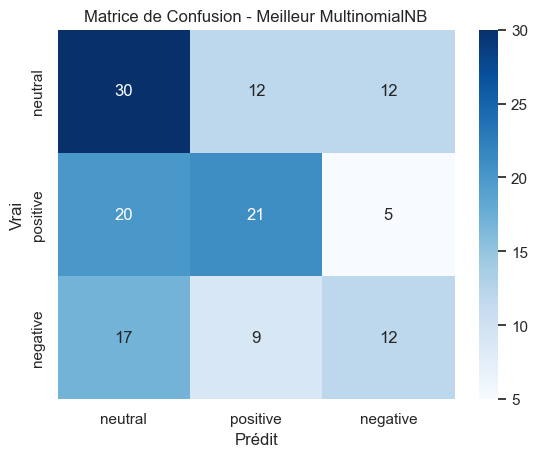

In [ ]:
# X.1.2. Optimisation avec GridSearchCV (sur texte lemmatisé si meilleur, sinon stemmatisé)

# Choisir sur quel texte travailler (stemmatisé ou lemmatisé)
# Disons que lemmatisé a donné de meilleurs résultats (à vérifier avec le code X.1.1)
# Si stemming est meilleur, utiliser X_train[text_feature] et X_test[text_feature]
current_best_text_train = X_train_lem['lemmatized_text']
current_best_text_test = X_test_lem['lemmatized_text']
# ou
# current_best_text_train = X_train[text_feature] # si stemming est mieux
# current_best_text_test = X_test[text_feature]

# Définir le pipeline pour GridSearchCV
pipeline_mnb_gs = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

# Définir la grille de paramètres à tester
# Attention: une grille trop large peut être très longue à calculer sur un petit dataset
# avec peu de folds de CV.
parameters_mnb = {
    'tfidf__ngram_range': [(1, 1), (1, 2)], # Unigrammes seuls ou unigrammes+bigrammes
    'tfidf__min_df': [1, 2, 3],          # Fréquence minimale de document
    'tfidf__max_df': [0.9, 0.95, 1.0],     # Fréquence maximale de document (proportion)
    'tfidf__use_idf': (True, False),
    'tfidf__smooth_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'classifier__alpha': [0.01, 0.1, 0.5, 1.0, 1.5] # Paramètre de lissage pour MNB
}

# Configurer GridSearchCV
# cv=3 ou 5. Avec 256 données d'entraînement, 5 folds = ~50 données par fold.
# Un nombre plus petit de folds (ex: 3) est parfois plus stable sur petits datasets.
# StratifiedKFold est utilisé par défaut pour les classifieurs.
grid_search_mnb = GridSearchCV(pipeline_mnb_gs, parameters_mnb, cv=5, # ou cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
                               scoring=make_scorer(f1_score, average='weighted'),
                               n_jobs=-1, verbose=1) # n_jobs=-1 utilise tous les coeurs

print(f"\n--- Lancement de GridSearchCV pour MultinomialNB ---")
grid_search_mnb.fit(current_best_text_train, y_train)

print("\nMeilleurs paramètres trouvés pour MultinomialNB :")
print(grid_search_mnb.best_params_)
print(f"Meilleur F1-score (pondéré) de validation croisée : {grid_search_mnb.best_score_:.4f}")

# Évaluation du meilleur modèle MNB sur le jeu de test
best_mnb_pipeline = grid_search_mnb.best_estimator_
y_pred_best_mnb = best_mnb_pipeline.predict(current_best_text_test)

accuracy_best_mnb = accuracy_score(y_test, y_pred_best_mnb)
f1_best_mnb = f1_score(y_test, y_pred_best_mnb, average='weighted')
report_best_mnb = classification_report(y_test, y_pred_best_mnb, target_names=['neutral (0)', 'positive (1)', 'negative (2)'])
cm_best_mnb = confusion_matrix(y_test, y_pred_best_mnb)

print(f"\nMeilleur MultinomialNB (après GridSearchCV) - Accuracy: {accuracy_best_mnb:.4f}")
print(f"Meilleur MultinomialNB (après GridSearchCV) - F1-Score (Weighted): {f1_best_mnb:.4f}")
print("Classification Report:\n", report_best_mnb)
print("Confusion Matrix:\n", cm_best_mnb)
sns.heatmap(cm_best_mnb, annot=True, fmt='d', cmap='Blues', xticklabels=['neutral', 'positive', 'negative'], yticklabels=['neutral', 'positive', 'negative'])
plt.title('Matrice de Confusion - Meilleur MultinomialNB')
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.show()

# Mettre à jour les résultats pour comparaison future
results_text_only['Multinomial NB Optimized'] = {
    'model': best_mnb_pipeline,
    'accuracy': accuracy_best_mnb,
    'f1_weighted': f1_best_mnb,
    'report': report_best_mnb,
    'confusion_matrix': cm_best_mnb
}

# X.2. Test et Optimisation de LinearSVC


--- Lancement de GridSearchCV pour LinearSVC ---
Fitting 5 folds for each of 540 candidates, totalling 2700 fits

Meilleurs paramètres trouvés pour LinearSVC :
{'classifier__C': 10, 'tfidf__max_df': 0.85, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3), 'tfidf__norm': 'l2', 'tfidf__use_idf': False}
Meilleur F1-score (pondéré) de validation croisée : 0.6047

Meilleur LinearSVC (après GridSearchCV) - Accuracy: 0.5217
Meilleur LinearSVC (après GridSearchCV) - F1-Score (Weighted): 0.5199
Classification Report:
               precision    recall  f1-score   support

 neutral (0)       0.52      0.57      0.54        54
positive (1)       0.54      0.54      0.54        46
negative (2)       0.50      0.42      0.46        38

    accuracy                           0.52       138
   macro avg       0.52      0.51      0.51       138
weighted avg       0.52      0.52      0.52       138

Confusion Matrix:
 [[31 14  9]
 [14 25  7]
 [15  7 16]]


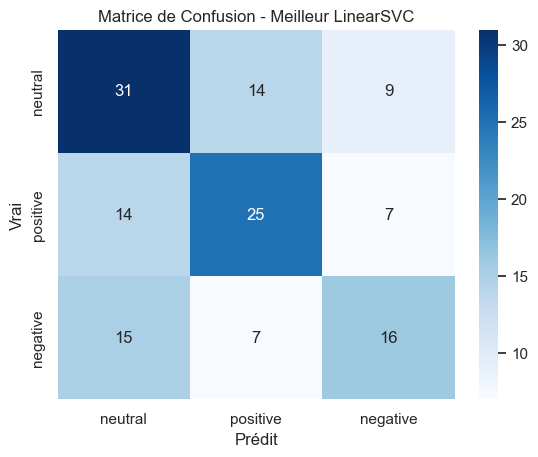

In [ ]:
# X.2. Test et Optimisation de LinearSVC

pipeline_svc_gs = Pipeline([
    ('tfidf', TfidfVectorizer()), # On optimisera aussi ses paramètres
    ('classifier', SVC(kernel='linear', probability=True, random_state=SEED))
])

parameters_svc = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1,3)], # Tester aussi trigrammes
    'tfidf__min_df': [1, 2, 3],
    'tfidf__max_df': [0.85, 0.9, 0.95],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'classifier__C': [0.1, 0.5, 1, 5, 10] # Paramètre de régularisation pour SVC
}

grid_search_svc = GridSearchCV(pipeline_svc_gs, parameters_svc, cv=5,
                               scoring=make_scorer(f1_score, average='weighted'),
                               n_jobs=-1, verbose=1)

print(f"\n--- Lancement de GridSearchCV pour LinearSVC ---")
# Utiliser le même current_best_text_train que pour MNB (lemmatisé ou stemmatisé)
grid_search_svc.fit(current_best_text_train, y_train)

print("\nMeilleurs paramètres trouvés pour LinearSVC :")
print(grid_search_svc.best_params_)
print(f"Meilleur F1-score (pondéré) de validation croisée : {grid_search_svc.best_score_:.4f}")

best_svc_pipeline = grid_search_svc.best_estimator_
y_pred_best_svc = best_svc_pipeline.predict(current_best_text_test)

accuracy_best_svc = accuracy_score(y_test, y_pred_best_svc)
f1_best_svc = f1_score(y_test, y_pred_best_svc, average='weighted')
report_best_svc = classification_report(y_test, y_pred_best_svc, target_names=['neutral (0)', 'positive (1)', 'negative (2)'])
cm_best_svc = confusion_matrix(y_test, y_pred_best_svc)

print(f"\nMeilleur LinearSVC (après GridSearchCV) - Accuracy: {accuracy_best_svc:.4f}")
print(f"Meilleur LinearSVC (après GridSearchCV) - F1-Score (Weighted): {f1_best_svc:.4f}")
print("Classification Report:\n", report_best_svc)
print("Confusion Matrix:\n", cm_best_svc)
sns.heatmap(cm_best_svc, annot=True, fmt='d', cmap='Blues', xticklabels=['neutral', 'positive', 'negative'], yticklabels=['neutral', 'positive', 'negative'])
plt.title('Matrice de Confusion - Meilleur LinearSVC')
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.show()

results_text_only['LinearSVC Optimized'] = {
    'model': best_svc_pipeline,
    'accuracy': accuracy_best_svc,
    'f1_weighted': f1_best_svc,
    'report': report_best_svc,
    'confusion_matrix': cm_best_svc
}

# X.3. Combinaison de Modèles avec VotingClassifier


--- Entraînement du VotingClassifier (soft) ---
VotingClassifier - Accuracy: 0.4493
VotingClassifier - F1-Score (Weighted): 0.4366
Classification Report:
               precision    recall  f1-score   support

 neutral (0)       0.43      0.61      0.50        54
positive (1)       0.51      0.43      0.47        46
negative (2)       0.41      0.24      0.30        38

    accuracy                           0.45       138
   macro avg       0.45      0.43      0.42       138
weighted avg       0.45      0.45      0.44       138

Confusion Matrix:
 [[33 12  9]
 [22 20  4]
 [22  7  9]]


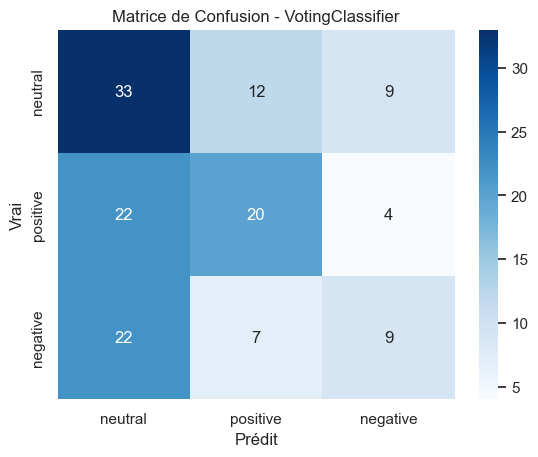

In [ ]:
# X.3. Combinaison de Modèles avec VotingClassifier

from sklearn.ensemble import VotingClassifier

# Récupérer les meilleurs pipelines individuels après GridSearchCV
# S'assurer qu'ils ont été entraînés avec les mêmes features textuelles (lemmatized_text ou cleaned_text)

# Modèle 1: Meilleur Naive Bayes
clf1 = grid_search_mnb.best_estimator_ # Ou le MNB de base si GridSearchCV n'a pas amélioré

# Modèle 2: Meilleur LinearSVC
clf2 = grid_search_svc.best_estimator_ # Ou le SVC de base

# Modèle 3 (Optionnel): Meilleur Logistic Regression (si optimisé)
# Exemple: on reprend celui de la Phase 2 pour l'instant
# Il faut s'assurer que son étape tfidf est la même ou l'optimiser aussi
# Pour l'exemple, on le reconstruit avec les paramètres TF-IDF du meilleur MNB (par exemple)
# best_tfidf_params = {k.split('__')[1]: v for k,v in grid_search_mnb.best_params_.items() if 'tfidf__' in k}
# clf3 = Pipeline([
#     ('tfidf', TfidfVectorizer(**best_tfidf_params)),
#     ('classifier', LogisticRegression(random_state=SEED, max_iter=1000, C=1.0, solver='liblinear'))
# ])
# Il est plus propre d'avoir un grid_search_lr.best_estimator_ aussi.
# Pour simplifier, on va prendre celui de results_text_only si on n'a pas fait de GS dessus.
clf3 = results_text_only['Logistic Regression']['model']


# Créer le VotingClassifier
# 'soft' voting est souvent meilleur mais nécessite predict_proba pour tous les classifieurs.
# NaiveBayes, LogisticRegression, SVC(probability=True) le permettent.
# XGBoost aussi.

# S'assurer que les classifieurs dans les pipelines sont nommés 'classifier'
# et que les préprocesseurs sont nommés 'tfidf' ou que le pipeline est le même pour tous.
# Ici, nos pipelines clf1 et clf2 ont déjà le TF-IDF intégré et optimisé.
# Pour clf3, s'il vient de results_text_only, son TF-IDF est celui par défaut de la phase 2.
# Il est préférable que tous les modèles partagent le même prétraitement de texte
# ou que chacun ait son prétraitement optimisé.

# Option 1: Chaque modèle a son propre pipeline TF-IDF optimisé
# (C'est ce que clf1 et clf2 de GridSearchCV font)
# Il faudrait s'assurer que clf3 aussi a son pipeline optimisé si on veut l'inclure.

# Option 2 (plus simple pour commencer si les TF-IDF sont similaires):
# Extraire les classifieurs et utiliser un TF-IDF commun.
# tfidf_common_params = grid_search_mnb.best_params_ # Prendre les params TF-IDF d'un des bons modèles
# tfidf_common_params = {k.replace('tfidf__',''):v for k,v in tfidf_common_params.items() if 'tfidf__' in k}
# common_tfidf_transformer = TfidfVectorizer(**tfidf_common_params)

#estimators = [
#    ('mnb', clf1.named_steps['classifier']), # MNB de clf1 (après son TFIDF)
#    ('svc', clf2.named_steps['classifier'])  # SVC de clf2 (après son TFIDF)
#]
# Ici, on ne peut pas faire ça directement car le VotingClassifier s'attend à des estimateurs
# qui prennent le texte brut en entrée si on utilise un TFIDF commun AVANT le voting.

# Le plus simple est de passer les pipelines complets au VotingClassifier,
# MAIS VotingClassifier ne prend pas de pipelines directement comme estimateurs
# s'ils ont des étapes de transformation avec des noms identiques (comme 'tfidf').
# Une solution est de wrapper chaque pipeline dans un autre pipeline pour leur donner des noms uniques
# ou d'utiliser un ColumnTransformer si les entrées étaient différentes.

# Solution plus directe: Voting sur les classifieurs eux-mêmes après une transformation commune.
# On va d'abord appliquer la MEILLEURE transformation TF-IDF (issue d'un des GridSearchCV)
# aux données, PUIS faire le voting sur les classifieurs nus.

best_tfidf_pipeline_step = grid_search_mnb.best_estimator_.steps[0][1] # Ex: TF-IDF du meilleur MNB

# Pré-transformer les données
X_train_transformed_for_voting = best_tfidf_pipeline_step.fit_transform(current_best_text_train)
X_test_transformed_for_voting = best_tfidf_pipeline_step.transform(current_best_text_test)

# Classifieurs nus (sans leur propre TF-IDF car on l'a appliqué avant)
mnb_classifier = grid_search_mnb.best_estimator_.steps[1][1]
svc_classifier = grid_search_svc.best_estimator_.steps[1][1]
lr_classifier = results_text_only['Logistic Regression']['model'].steps[1][1] # Celui de base

voting_clf = VotingClassifier(
    estimators=[
        ('mnb', mnb_classifier),
        ('svc', svc_classifier),
        ('lr', lr_classifier)
    ],
    voting='soft', # Tenter 'soft' si tous supportent predict_proba et sont calibrés
    weights=[0.4, 0.4, 0.2] # Optionnel: donner plus de poids aux meilleurs modèles
                            # (à ajuster en fonction des perfs de validation croisée)
)

print(f"\n--- Entraînement du VotingClassifier (soft) ---")
voting_clf.fit(X_train_transformed_for_voting, y_train)
y_pred_voting = voting_clf.predict(X_test_transformed_for_voting)

accuracy_voting = accuracy_score(y_test, y_pred_voting)
f1_voting = f1_score(y_test, y_pred_voting, average='weighted')
report_voting = classification_report(y_test, y_pred_voting, target_names=['neutral (0)', 'positive (1)', 'negative (2)'])
cm_voting = confusion_matrix(y_test, y_pred_voting)

print(f"VotingClassifier - Accuracy: {accuracy_voting:.4f}")
print(f"VotingClassifier - F1-Score (Weighted): {f1_voting:.4f}")
print("Classification Report:\n", report_voting)
print("Confusion Matrix:\n", cm_voting)
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Blues', xticklabels=['neutral', 'positive', 'negative'], yticklabels=['neutral', 'positive', 'negative'])
plt.title('Matrice de Confusion - VotingClassifier')
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.show()

results_text_only['VotingClassifier Soft'] = {
    'model': voting_clf, # Attention, ce modèle attend des données déjà transformées par TF-IDF
    'accuracy': accuracy_voting,
    'f1_weighted': f1_voting,
    'report': report_voting,
    'confusion_matrix': cm_voting
}

# X.4. Comparaison Finale des Modèles "Texte Seul" (Après Améliorations)


--- Comparaison Finale des Modèles (Text Only - Améliorés) ---
                          Accuracy  F1 Weighted
LinearSVC Optimized       0.521739     0.519854
Multinomial NB            0.492754     0.466620
SVC (Linear)              0.471014     0.463328
Logistic Regression       0.492754     0.453230
Multinomial NB Optimized  0.456522     0.451763
VotingClassifier Soft     0.449275     0.436617
XGBoost                   0.434783     0.405827


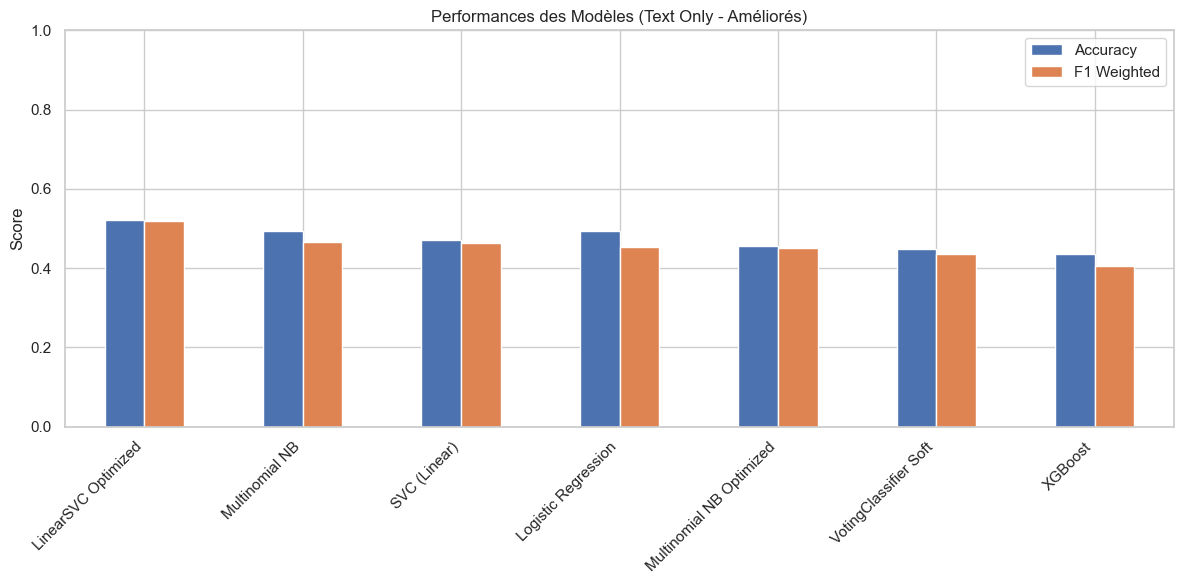


Meilleur modèle texte seul final : LinearSVC Optimized avec F1-score = 0.5199


In [ ]:
# X.4. Comparaison Finale des Modèles "Texte Seul" (Après Améliorations)
print("\n--- Comparaison Finale des Modèles (Text Only - Améliorés) ---")

# S'assurer que results_text_only contient bien tous les nouveaux résultats
results_df_text_improved = pd.DataFrame({
    model_name: {'Accuracy': res['accuracy'], 'F1 Weighted': res['f1_weighted']}
    for model_name, res in results_text_only.items() # Utiliser tous les modèles testés
}).T.sort_values(by='F1 Weighted', ascending=False)

print(results_df_text_improved)
results_df_text_improved.plot(kind='bar', figsize=(12, 6), title='Performances des Modèles (Text Only - Améliorés)')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1) # Ajuster si nécessaire, par exemple (0.3, 0.7) pour mieux voir les différences
plt.tight_layout()
plt.show()

# Identifier le tout meilleur modèle texte seul pour la section du rapport
best_final_text_model_name = results_df_text_improved.index[0]
best_final_text_f1 = results_df_text_improved.loc[best_final_text_model_name, 'F1 Weighted']
print(f"\nMeilleur modèle texte seul final : {best_final_text_model_name} avec F1-score = {best_final_text_f1:.4f}")

# Meilleur modèle texte seul final : LinearSVC Optimized avec F1-score = 0.5199


# X.bis.1. Impact de la Taille du Jeu d'Entraînement

In [ ]:
print("\n" + "="*80)
print(" Phase X.bis : Tentatives d'Amélioration Supplémentaires pour LinearSVC Optimisé")
print("="*80 + "\n")

print("X.bis.1. Impact de la Taille du Jeu d'Entraînement sur LinearSVC Optimisé")

# Récupérer le meilleur pipeline LinearSVC déjà optimisé (celui qui a donné ~0.52 F1)
# S'il n'est pas stocké dans une variable globale, il faut le recréer avec les best_params_
# Assumons que 'best_svc_pipeline' est disponible globalement et contient le meilleur estimateur de grid_search_svc
if 'best_svc_pipeline' not in globals() or best_svc_pipeline is None:
    print("Erreur: 'best_svc_pipeline' non trouvé. Veuillez le définir avec le meilleur estimateur SVC de GridSearchCV.")
    # Recréer le pipeline avec les meilleurs paramètres trouvés précédemment pour SVC
    # Exemple de paramètres (à adapter avec TES VRAIS meilleurs paramètres)
    best_svc_params = {
        'classifier__C': 10,
        'tfidf__max_df': 0.85,
        'tfidf__min_df': 1,
        'tfidf__ngram_range': (1, 3),
        'tfidf__norm': 'l2',
        'tfidf__use_idf': False
    }
    
    current_best_svc_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_df=best_svc_params['tfidf__max_df'],
            min_df=best_svc_params['tfidf__min_df'],
            ngram_range=best_svc_params['tfidf__ngram_range'],
            norm=best_svc_params['tfidf__norm'],
            use_idf=best_svc_params['tfidf__use_idf'],
            max_features=5000 # Garder le max_features de la phase 2 ou celui du GS si différent
        )),
        ('classifier', SVC(kernel='linear', probability=True, random_state=SEED, C=best_svc_params['classifier__C']))
    ])
else:
    current_best_svc_pipeline = best_svc_pipeline


# Différentes tailles de test_size à essayer
test_sizes_to_try = [0.30, 0.25, 0.20] # Par exemple
# Rappel: X_train_lem et X_test_lem contenaient le texte lemmatisé
# Utiliser current_best_text_train et current_best_text_test qui pointent vers le texte lemmatisé
# ou recréer X_text_for_exp à partir de df['lemmatized_text'] si besoin (pour être sûr de partir de la même base)
# Pour être propre, on va repartir de la colonne de df qui a été utilisée pour le GridSearchCV de SVC

# Identifier la colonne texte utilisée pour l'entraînement du best_svc_pipeline
# Si c'était lemmatized_text :
text_column_for_svc_champion = X_train_lem['lemmatized_text'].name # ou directement 'lemmatized_text'
# S'assurer que df contient bien cette colonne (après l'étape X.1.1)
if text_column_for_svc_champion not in df.columns:
    # Si la colonne 'lemmatized_text' n'est pas dans le df global, il faut la recréer
    print(f"Recréation de la colonne '{text_column_for_svc_champion}' dans df global...")
    if 'text' not in df.columns: # S'assurer que le texte original est là
        # Recharger df au besoin ou s'arrêter
        raise ValueError("Colonne 'text' originale non trouvée dans df pour lemmatisation globale.")
    df[text_column_for_svc_champion] = df['text'].apply(preprocess_text_lemmatization)

X_for_new_split = df[text_column_for_svc_champion] # Les features textuelles
y_for_new_split = df['sentiment_encoded']      # La cible

results_test_size_impact = {}

for ts_size in test_sizes_to_try:
    print(f"\n--- Test avec test_size = {ts_size} ---")
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
        X_for_new_split, y_for_new_split,
        test_size=ts_size,
        random_state=SEED, # Garder le même random_state pour la comparabilité du split
        stratify=y_for_new_split
    )
    
    print(f"Nouvelle taille entraînement: {X_train_new.shape[0]}, Nouvelle taille test: {X_test_new.shape[0]}")

    # Cloner le pipeline pour éviter de modifier l'original si on refait la boucle
    # current_best_svc_pipeline est déjà un pipeline, pas besoin de le cloner pour fit
    current_best_svc_pipeline.fit(X_train_new, y_train_new)
    y_pred_new_split = current_best_svc_pipeline.predict(X_test_new)
    
    f1_new_split = f1_score(y_test_new, y_pred_new_split, average='weighted')
    accuracy_new_split = accuracy_score(y_test_new, y_pred_new_split)
    report_new_split = classification_report(y_test_new, y_pred_new_split, target_names=['neutral (0)', 'positive (1)', 'negative (2)'])
    
    results_test_size_impact[ts_size] = {
        'f1_weighted': f1_new_split,
        'accuracy': accuracy_new_split,
        'report': report_new_split,
        'train_size': X_train_new.shape[0],
        'test_size_samples': X_test_new.shape[0]
    }
    
    print(f"F1-Score (Weighted) pour test_size={ts_size}: {f1_new_split:.4f}")
    print(f"Accuracy pour test_size={ts_size}: {accuracy_new_split:.4f}")
    # print("Rapport de classification:\n", report_new_split)

# Afficher un résumé des impacts de test_size
print("\n--- Impact de test_size sur LinearSVC Optimisé ---")
for ts, res in results_test_size_impact.items():
    print(f"Test Size: {ts*100:.0f}% (Train: {res['train_size']}, Test: {res['test_size_samples']}) -> F1-Score: {res['f1_weighted']:.4f}, Accuracy: {res['accuracy']:.4f}")

# Sélectionner le meilleur test_size
best_ts_f1 = -1
best_ts_value = None
for ts, res in results_test_size_impact.items():
    if res['f1_weighted'] > best_ts_f1:
        best_ts_f1 = res['f1_weighted']
        best_ts_value = ts

print(f"\nMeilleur F1-score ({best_ts_f1:.4f}) obtenu avec test_size = {best_ts_value}")

# Mettre à jour X_train, X_test, y_train, y_test avec le meilleur split pour la suite
if best_ts_value is not None:
    print(f"Mise à jour des jeux d'entraînement/test avec test_size = {best_ts_value}")
    X_train, X_test, y_train, y_test = train_test_split(
        X_for_new_split, y_for_new_split, # X_for_new_split contient seulement la colonne texte
        test_size=best_ts_value,
        random_state=SEED,
        stratify=y_for_new_split
    )
    # Important: current_best_text_train et current_best_text_test doivent aussi être mis à jour
    # pour les étapes suivantes si elles dépendent de ces variables spécifiques.
    # Ou alors, s'assurer que les étapes suivantes utilisent X_train et X_test directement.
    # Pour la courbe d'apprentissage suivante, elle utilisera ce X_train et y_train.
else:
    print("Aucun test_size n'a été évalué ou n'a donné de résultat.")


 Phase X.bis : Tentatives d'Amélioration Supplémentaires pour LinearSVC Optimisé

X.bis.1. Impact de la Taille du Jeu d'Entraînement sur LinearSVC Optimisé
Recréation de la colonne 'lemmatized_text' dans df global...

--- Test avec test_size = 0.3 ---
Nouvelle taille entraînement: 275, Nouvelle taille test: 119
F1-Score (Weighted) pour test_size=0.3: 0.4889
Accuracy pour test_size=0.3: 0.4958

--- Test avec test_size = 0.25 ---
Nouvelle taille entraînement: 295, Nouvelle taille test: 99
F1-Score (Weighted) pour test_size=0.25: 0.4571
Accuracy pour test_size=0.25: 0.4646

--- Test avec test_size = 0.2 ---
Nouvelle taille entraînement: 315, Nouvelle taille test: 79
F1-Score (Weighted) pour test_size=0.2: 0.4422
Accuracy pour test_size=0.2: 0.4430

--- Impact de test_size sur LinearSVC Optimisé ---
Test Size: 30% (Train: 275, Test: 119) -> F1-Score: 0.4889, Accuracy: 0.4958
Test Size: 25% (Train: 295, Test: 99) -> F1-Score: 0.4571, Accuracy: 0.4646
Test Size: 20% (Train: 315, Test: 79) -

# X.bis.2. Courbe d'Apprentissage Détaillée pour LinearSVC Optimisé (avec le meilleur test_size)


--- Courbe d'Apprentissage pour LinearSVC Optimisé (avec meilleur test_size) ---


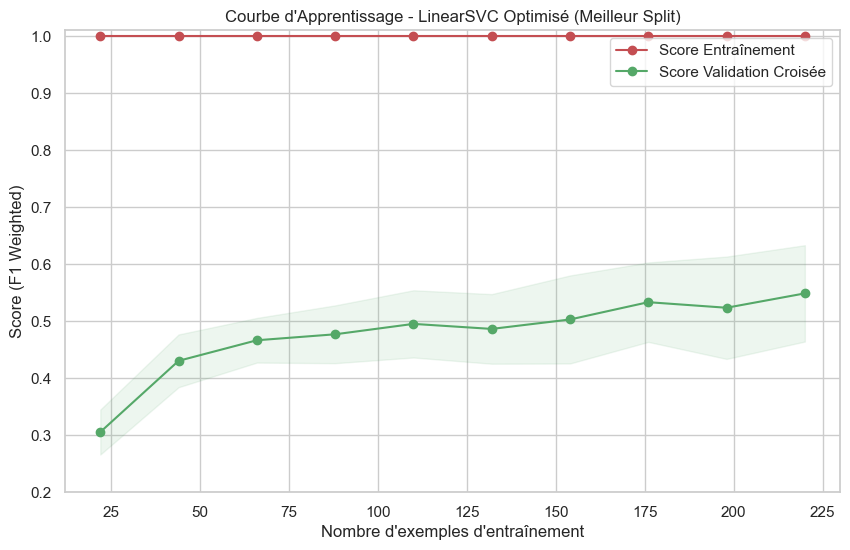


Données pour la courbe d'apprentissage (LinearSVC Optimisé) :
Tailles d'entraînement: [ 22  44  66  88 110 132 154 176 198 220]
Scores moyens d'entraînement: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Scores moyens de validation croisée: [0.30539548 0.43027125 0.46633304 0.47680756 0.49504644 0.4862249
 0.50277627 0.53310124 0.52333219 0.54852657]


In [ ]:
print("\n--- Courbe d'Apprentissage pour LinearSVC Optimisé (avec meilleur test_size) ---")
# S'assurer que 'current_best_svc_pipeline' est bien le pipeline SVC optimisé
# et que X_train, y_train sont ceux du meilleur split
if 'current_best_svc_pipeline' in globals() and current_best_svc_pipeline is not None:
    # La fonction plot_learning_curve utilise X et y passés en arguments.
    # X_train ici est une Series de textes. Le pipeline current_best_svc_pipeline s'en charge.
    plot_learning_curve(current_best_svc_pipeline,
                        "Courbe d'Apprentissage - LinearSVC Optimisé (Meilleur Split)",
                        X_train, y_train, # Utilise les X_train, y_train mis à jour
                        ylim=(0.2, 1.01), cv=5) # cv=5 ou 3
    plt.show()

    # Pour que tu puisses interpréter, voici les données qui seraient utiles (la fonction les retourne)
    # (Ce code est pour illustrer, la fonction plot_learning_curve le fait déjà en interne)
    f1_scorer_lc = make_scorer(f1_score, average='weighted')
    train_sizes_lc, train_scores_lc, validation_scores_lc = learning_curve(
       current_best_svc_pipeline, X_train, y_train, cv=5, scoring=f1_scorer_lc,
       train_sizes=np.linspace(.1, 1.0, 10), n_jobs=-1)
    
    print("\nDonnées pour la courbe d'apprentissage (LinearSVC Optimisé) :")
    print("Tailles d'entraînement:", train_sizes_lc)
    print("Scores moyens d'entraînement:", np.mean(train_scores_lc, axis=1))
    print("Scores moyens de validation croisée:", np.mean(validation_scores_lc, axis=1))
else:
    print("current_best_svc_pipeline n'est pas défini. Exécutez d'abord GridSearchCV pour SVC.")


--- Ré-Optimisation de LinearSVC sur le nouveau jeu d'entraînement ---
Lancement de GridSearchCV pour LinearSVC (raffiné) sur 275 échantillons d'entraînement...
Fitting 5 folds for each of 576 candidates, totalling 2880 fits

Meilleurs paramètres trouvés pour LinearSVC (raffiné) :
{'classifier__C': 1, 'classifier__class_weight': 'balanced', 'tfidf__max_df': 0.85, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3), 'tfidf__norm': 'l2', 'tfidf__use_idf': False}
Meilleur F1-score (pondéré) de validation croisée (raffiné) : 0.5639

Meilleur LinearSVC (raffiné) - Accuracy: 0.4706
Meilleur LinearSVC (raffiné) - F1-Score (Weighted): 0.4702
Classification Report:
               precision    recall  f1-score   support

 neutral (0)       0.47      0.54      0.51        46
positive (1)       0.56      0.47      0.51        40
negative (2)       0.38      0.36      0.37        33

    accuracy                           0.47       119
   macro avg       0.47      0.46      0.46       119
weighted a

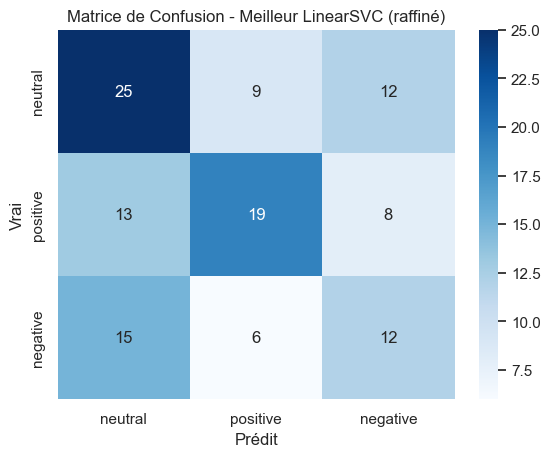

In [ ]:
print("\n--- Ré-Optimisation de LinearSVC sur le nouveau jeu d'entraînement ---")

# S'assurer que X_train et y_train sont ceux du meilleur split
# current_best_text_train a été mis à jour implicitement si X_train l'a été et qu'il est une Series

# Nouveau pipeline pour GridSearchCV (important de ne pas réutiliser l'ancien objet GS)
pipeline_svc_gs_refined = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)), # max_features est important à garder ou à optimiser
    ('classifier', SVC(kernel='linear', probability=True, random_state=SEED))
])

parameters_svc_refined = {
    'tfidf__ngram_range': [(1, 2), (1, 3)], # On a vu que (1,3) était bien
    'tfidf__min_df': [1, 2, 3],           # Tester des valeurs > 1
    'tfidf__max_df': [0.85, 0.9, 0.95],   # Garder ces valeurs
    'tfidf__use_idf': [True, False],      # Retester avec True
    'tfidf__norm': ['l1', 'l2'],
    'classifier__C': [1, 5, 10, 15],       # Affiner autour de 10
    'classifier__class_weight': [None, 'balanced'] # Tester class_weight
}

grid_search_svc_refined = GridSearchCV(pipeline_svc_gs_refined, parameters_svc_refined, cv=5,
                                       scoring=make_scorer(f1_score, average='weighted'),
                                       n_jobs=-1, verbose=1)

print(f"Lancement de GridSearchCV pour LinearSVC (raffiné) sur {X_train.shape[0]} échantillons d'entraînement...")
# X_train ici est la Series de textes du meilleur split
grid_search_svc_refined.fit(X_train, y_train)

print("\nMeilleurs paramètres trouvés pour LinearSVC (raffiné) :")
print(grid_search_svc_refined.best_params_)
print(f"Meilleur F1-score (pondéré) de validation croisée (raffiné) : {grid_search_svc_refined.best_score_:.4f}")

# Évaluation du MEILLEUR modèle SVC raffiné sur le jeu de test (X_test du meilleur split)
best_svc_pipeline_refined = grid_search_svc_refined.best_estimator_
y_pred_best_svc_refined = best_svc_pipeline_refined.predict(X_test)

accuracy_best_svc_refined = accuracy_score(y_test, y_pred_best_svc_refined)
f1_best_svc_refined = f1_score(y_test, y_pred_best_svc_refined, average='weighted')
report_best_svc_refined = classification_report(y_test, y_pred_best_svc_refined, target_names=['neutral (0)', 'positive (1)', 'negative (2)'])
cm_best_svc_refined = confusion_matrix(y_test, y_pred_best_svc_refined)

print(f"\nMeilleur LinearSVC (raffiné) - Accuracy: {accuracy_best_svc_refined:.4f}")
print(f"Meilleur LinearSVC (raffiné) - F1-Score (Weighted): {f1_best_svc_refined:.4f}")
print("Classification Report:\n", report_best_svc_refined)
print("Confusion Matrix:\n", cm_best_svc_refined)
sns.heatmap(cm_best_svc_refined, annot=True, fmt='d', cmap='Blues', xticklabels=['neutral', 'positive', 'negative'], yticklabels=['neutral', 'positive', 'negative'])
plt.title('Matrice de Confusion - Meilleur LinearSVC (raffiné)')
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.show()

# Mettre à jour/Ajouter ce résultat
results_text_only['LinearSVC Refined'] = {
    'model': best_svc_pipeline_refined,
    'accuracy': accuracy_best_svc_refined,
    'f1_weighted': f1_best_svc_refined,
    'report': report_best_svc_refined,
    'confusion_matrix': cm_best_svc_refined
}

# Ne pas oublier de retracer le tableau comparatif final des modèles
# (Code de la section X.4 à reprendre ici pour inclure 'LinearSVC Refined')